# Univariate Volatility Modeling
## Week 5
### Kevin Sheppard

# Topic Outline

* Asymmetric Extensions
* Model Building
* Specification Checking
* Alternative Distributional Assumptions
* Forecasting
* Forecast Evaluation

In [1]:
import matplotlib.pyplot as plt
import mfe
import numpy as np
import pandas as pd
import warnings

mfe.outputs["pres"]()
import arch
from arch import arch_model
from arch.univariate.distribution import StudentsT
from arch.univariate.mean import ZeroMean
from arch.univariate.volatility import GARCH
from mfe.slides import figsize, plot, pretty, summary, truncated_plot

warnings.filterwarnings("ignore",message="Values in x were outside",category=RuntimeWarning)

## Data
SPY
FTSE 100
WTI
GLD
BitCoin


## Outline

1. Visualizing Heteroskedastic Data
2. ARCH model estimation
3. Residual Analysis
4. GARCH Model Estimation
5. EWMA Model Estimation
5. GJR-GARCH Model Estimation
6. TARCH Estimation
6. EGARCH Estimation
7. APARCH Estimation
8. Specification Checking
9. Model Building
10. Forecasting
11. Forecast Eval
  * Absolute
  * GLS
  * Relative
12. Realized Variance
13. RV Succes
14. RV Failure - simulated data
15. Volatility Signature
16. RV Forecasting HAR
17. RV Forecasting Log
18. RV Forecasting ARCH-type
19. HARCH
20. RV volatility model evaluation ??
21. VIX
22. VIX Dynamics
23. Variance Risk Premium

In [2]:
import os

import mfe
import seaborn as sns
from scipy import stats
from statsmodels.iolib import SimpleTable
from statsmodels.iolib.summary import Summary, fmt_2cols, fmt_params
from statsmodels.stats.diagnostic import het_arch

h5_file = "univariate-volatility-data.h5"

if os.path.exists(h5_file):
    sp500 = pd.read_hdf(h5_file, "sp500")
    ftse100 = pd.read_hdf(h5_file, "ftse100")
    gold = pd.read_hdf(h5_file, "gold")
    wti = pd.read_hdf(h5_file, "wti")
    btc = pd.read_hdf(h5_file, "btc")
    eth = pd.read_hdf(h5_file, "eth")
    iid = pd.read_hdf(h5_file, "iid")
else:
    sp500 = (
        100
        * pd.read_csv("data/^GSPC.csv", index_col="Date", parse_dates=True)["Adj Close"]
        .pct_change()
        .dropna()["1980":]
    )
    gold = pd.read_csv(
        "data/GOLDPMGBD228NLBM.csv", index_col="DATE", parse_dates=True
    ).iloc[:, 0]["1980":]
    wti = pd.read_csv("data/DCOILWTICO.csv", index_col="DATE", parse_dates=True).iloc[
        :, 0
    ]
    btc = pd.read_csv("data/CBBTCUSD.csv", index_col="DATE", parse_dates=True).iloc[
        :, 0
    ]
    eth = pd.read_csv("data/CBETHUSD.csv", index_col="DATE", parse_dates=True).iloc[
        :, 0
    ]

    ftse100 = pd.read_html("data/FTSE100-table.html")
    ftse100 = ftse100[0].iloc[:-1].iloc[::-1]
    ftse100 = pd.to_numeric(ftse100.set_index("Date")["Adj Close**"], errors="coerce")
    ftse100.index = pd.to_datetime(ftse100.index)
    ftse100 = 100 * ftse100.dropna().pct_change().dropna()

    gold = 100 * pd.to_numeric(gold, errors="coerce").dropna().pct_change().dropna()
    btc = 100 * pd.to_numeric(btc, errors="coerce").dropna().pct_change().dropna()
    eth = 100 * pd.to_numeric(eth, errors="coerce").dropna().pct_change().dropna()
    btc = btc.loc[eth.index[0] :]

    wti = pd.to_numeric(wti, errors="coerce")
    wti.loc[wti <= 0] = np.nan
    wti = 100 * wti.dropna().pct_change().dropna()

    rs = np.random.RandomState(20210202)
    am = ZeroMean(sp500, volatility=GARCH(), distribution=StudentsT(random_state=rs))
    res = am.fit(disp="off")
    iid = pd.Series(
        am.simulate([sp500.var(), 0, 0, res.params.nu], sp500.shape[0]).data
    )
    iid.index = sp500.index

    sp500.name = "S&P 500"
    ftse100.name = "FTSE 100"
    gold.name = "GOLD Fixing"
    wti.name = "WTI Crude"
    btc.name = "Coinbase BTC"
    eth.name = "Coinbase Ethereum"

    data = {
        "sp500": sp500,
        "ftse100": ftse100,
        "gold": gold,
        "wti": wti,
        "btc": btc,
        "eth": eth,
        "iid": iid,
    }

    with pd.HDFStore("univariate-volatility-data.h5", mode="w") as store:
        for key, value in data.items():
            store.put(key, value)


def arch_lm(rets, lags):
    res = {}
    for lag in range(1, lags + 1):
        res[lag] = pd.Series(
            het_arch(rets - rets.mean(), lag)[:2], index=["ARCH LM", "P-value"]
        )
    df = pd.DataFrame(res).T
    fig, ax = plt.subplots(1, 2)
    ax[0].bar(np.arange(1, lags + 1), df.iloc[:, 0])
    yellow = "#ffff00"
    ax[0].plot(
        np.arange(1, lags + 1),
        stats.chi2.ppf(0.95, np.arange(1, lags + 1)),
        marker="^",
        linestyle="none",
        markerfacecolor=yellow,
        markeredgecolor="k",
        markersize=48,
        label="Crit. Val.",
    )
    ax[0].set_title("ARCH LM Statistic")
    ax[0].set_xlabel("P")
    ax[1].set_xlabel("P")
    ax[1].bar(np.arange(1, lags + 1), 100 * df.iloc[:, 1], color=mfe.colors[1])
    ax[1].set_ylim(0, 100)
    ax[1].set_yticks([20, 40, 60, 80, 100])
    ax[1].set_yticklabels([f"{v}\%" for v in ax[1].get_yticks()])
    ax[1].set_title("ARCH LM P-value")
    sns.despine()
    fig.tight_layout(pad=1.0)


def summary(res, head=True, mean=True):
    model = res.model
    model_name = model.name + " - " + model.volatility.name
    # Summary Header
    top_left = [
        ("Mean Model:", model.name),
        ("Vol Model:", model.volatility.name),
        ("Distribution:", model.distribution.name),
    ]

    top_right = [
        ("Log-Likelihood:", "%#10.6g" % res.loglikelihood),
        ("AIC:", "%#10.6g" % res.aic),
        ("BIC:", "%#10.6g" % res.bic),
    ]

    title = model_name + " Model Results"
    stubs = []
    vals = []
    for stub, val in top_left:
        stubs.append(stub)
        vals.append([val])
    table = SimpleTable(vals, txt_fmt=fmt_2cols, title=title, stubs=stubs)
    fmt = fmt_2cols
    fmt["data_fmts"][1] = "%18s"

    top_right = [("%-21s" % ("  " + k), v) for k, v in top_right]
    stubs = []
    vals = []
    for stub, val in top_right:
        stubs.append(stub)
        vals.append([val])
    table.extend_right(SimpleTable(vals, stubs=stubs))

    s = Summary()
    if head:
        s.tables.append(table)
    if mean:
        s.tables.extend(res.summary().tables[1:])
    else:
        s.tables.extend(res.summary().tables[2:])
    return s

# Asymmetries in Conditional Variance

# GJR-GARCH

* Adds asymmetry to GARCH model

$$ \sigma^2_t = \omega + \alpha_1 \epsilon_{t-1}^2 + \gamma_1 I_{[\epsilon_t-1<0]} \epsilon_{t-1}^2 + \beta_1 \sigma^2_{t-1} $$


# GJR-GARCH(1,1,) Model

In [3]:
summary(arch_model(ftse100, vol="garch", o=1).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12574.3
Vol Model:                  GJR-GARCH   AIC:                           25158.6
Distribution:                  Normal   BIC:                           25194.4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0245  8.442e-03      2.907  3.646e-03 [7.997e-03,4.109e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0207  3.938e-03      5.262  1.424e-07 [1.300e-02,2.844e-02]
alpha[1]       0.0263  6.720e-03      3.910  9.234e-05 [1.310e-02,3.945e-02]
gamma[1]       0.1126  1.802e-02      6.246  4.216e-10   [7.724e-02,  0.148]
beta[1]        0.8973  1.184e-02     75.758      0.000     [  0.874,  0.921]
============================================================================
"""

# The TARCH Model

* Changes model from variance to volatility

$$ \sigma_t = \omega + \alpha_1 |\epsilon_{t-1}| + \gamma_1 I_{[\epsilon_t-1<0]} |\epsilon_{t-1}| + \beta_1 \sigma_{t-1} $$


# TARCH(1,1,1)


In [4]:
summary(arch_model(ftse100, vol="garch", o=1, power=1).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Constant Mean - TARCH/ZARCH Model Results                   
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12566.9
Vol Model:                TARCH/ZARCH   AIC:                           25143.9
Distribution:                  Normal   BIC:                           25179.6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0204  8.517e-03      2.401  1.637e-02 [3.753e-03,3.714e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0230  4.398e-03      5.223  1.763e-07 [1.435e-02,3.159e-02]
alpha[1]       0.0409  7.306e-03      5.602  2.122e-08 [2.661e-02,5.525e-02]
gamma[1]       0.0980  1.332e-02      7.359  1.851e-13   [7.192e-02,  0.124]
beta[1]        0.9070  1.098e-02     82.581      0.000     [  0.885,  0.929]
============================================================================
"""

# Exponential GARCH

$$ \ln \sigma^2_t = \omega + \alpha_1 \left| \frac{\epsilon_{t-1}}{\sigma_{t-1}}  - \sqrt{\frac{2}{\pi}} \right| + \gamma_1 \frac{\epsilon_{t-1}}{\sigma_{t-1}} + \beta_1 \ln \sigma^2_{t-1} $$


# EGARCH(1,1,1)

In [5]:
summary(arch_model(ftse100, vol="egarch", o=1).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12565.9
Vol Model:                     EGARCH   AIC:                           25141.8
Distribution:                  Normal   BIC:                           25177.5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0214  5.550e-03      3.863  1.121e-04 [1.056e-02,3.232e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.3006e-04  1.948e-03      0.375      0.708 [-3.089e-03,4.549e-03]
alpha[1]       0.1605  1.612e-02      9.953  2.447e-23      [  0.129,  0.192]
gamma[1]      -0.0817  9.921e-03     -8.238  1.748e-16   [ -0.101,-6.229e-02]
beta[1]        0.9794  3.723e-03    263.034      0.000      [  0.972,  0.987]
=============================================================================
"""

# Asymmetric Power ARCH

* Parameterizes power in model

$$ \sigma^\delta_t = \omega + \alpha_1 \left(|\epsilon_{t-1}| + \gamma_1 \epsilon_{t-1}\right)^\delta + \beta_1 \sigma^\delta_{t-1} $$


# APARCH(1,1,1) Model

In [6]:
from arch.univariate import APARCH, ConstantMean

summary(ConstantMean(ftse100, volatility=APARCH()).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - APARCH Model Results                     
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12559.6
Vol Model:                     APARCH   AIC:                           25131.3
Distribution:                  Normal   BIC:                           25174.2
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0216  8.536e-03      2.527  1.151e-02 [4.838e-03,3.830e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0220  4.132e-03      5.325  1.009e-07 [1.391e-02,3.010e-02]
alpha[1]       0.0854  9.696e-03      8.805  1.314e-18   [6.637e-02,  0.104]
gamma[1]       0.4937  6.798e-02      7.262  3.816e-13     [  0.360,  0.627]
beta[1]        0.9048  1.096e-02     82.593      0.000     [  0.883,  0.926]
delta          1.3226      0.158      8.384  5.123e-17     [  1.013,  1.632]
============================================================================
"""

# ACF and PACF of $\epsilon^{2}_{t}$

* Time-varying volatility appears through persistence in $\epsilon^{2}_{t}$
  * Square is essential
* Standard tool is to plot ACF and PACF of $\hat{\epsilon}^{2}_{t}$
  * Estimate mean without time-varying volatility
* ACF indicates ARCH-like terms needed
* PACF indicates GARCH-like terms needed

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf


def acf_pacf_plot(y, lags, correct=False, title=None, size=mfe.DEFAULT_FIGSIZE[1]):
    figsize(y=size)
    a = acf(y, nlags=lags, fft=True)
    p = pacf(y, nlags=lags)
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    t = y.shape[0]
    ax[0].bar(x, a[1:])
    ax[1].bar(x, p[1:], color=mfe.colors[1])
    a_ci = p_ci = 1.96 * np.ones_like(a[1:]) / np.sqrt(t)
    if correct:
        a_ci = 1.96 * (1 + np.cumsum(a[:-1] ** 2)) / np.sqrt(t)
    x[0] = 0.5
    x[-1] = lags + 0.5
    ax[0].plot(x, a_ci, "k--", x, -a_ci, "k--")
    ax[1].plot(x, p_ci, "k--", x, -p_ci, "k--")
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("Autocorrelation")
    ax[1].set_title("Partial Autocorrelation")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()

# S&P 500

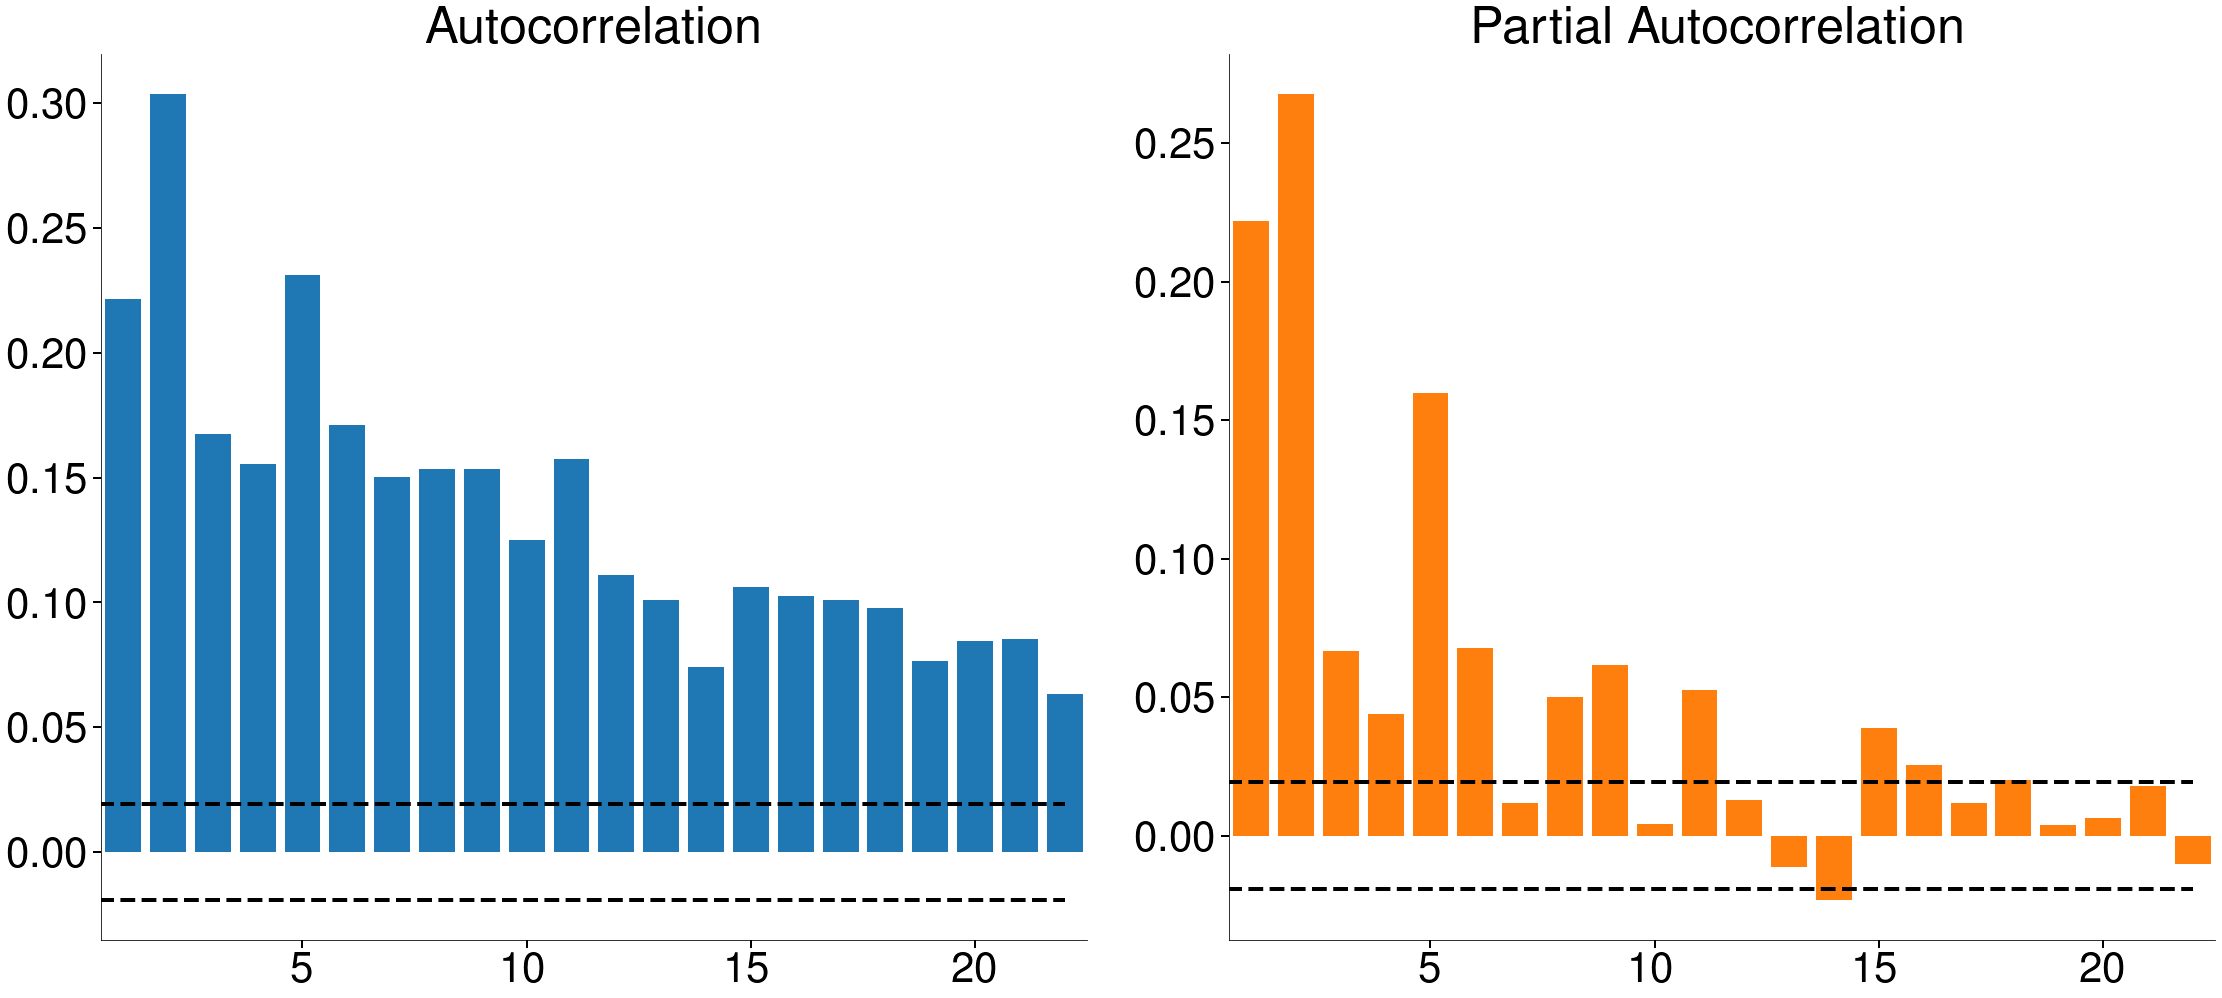

In [8]:
acf_pacf_plot(sp500 ** 2, 22)

# West Texas Internediate Crude

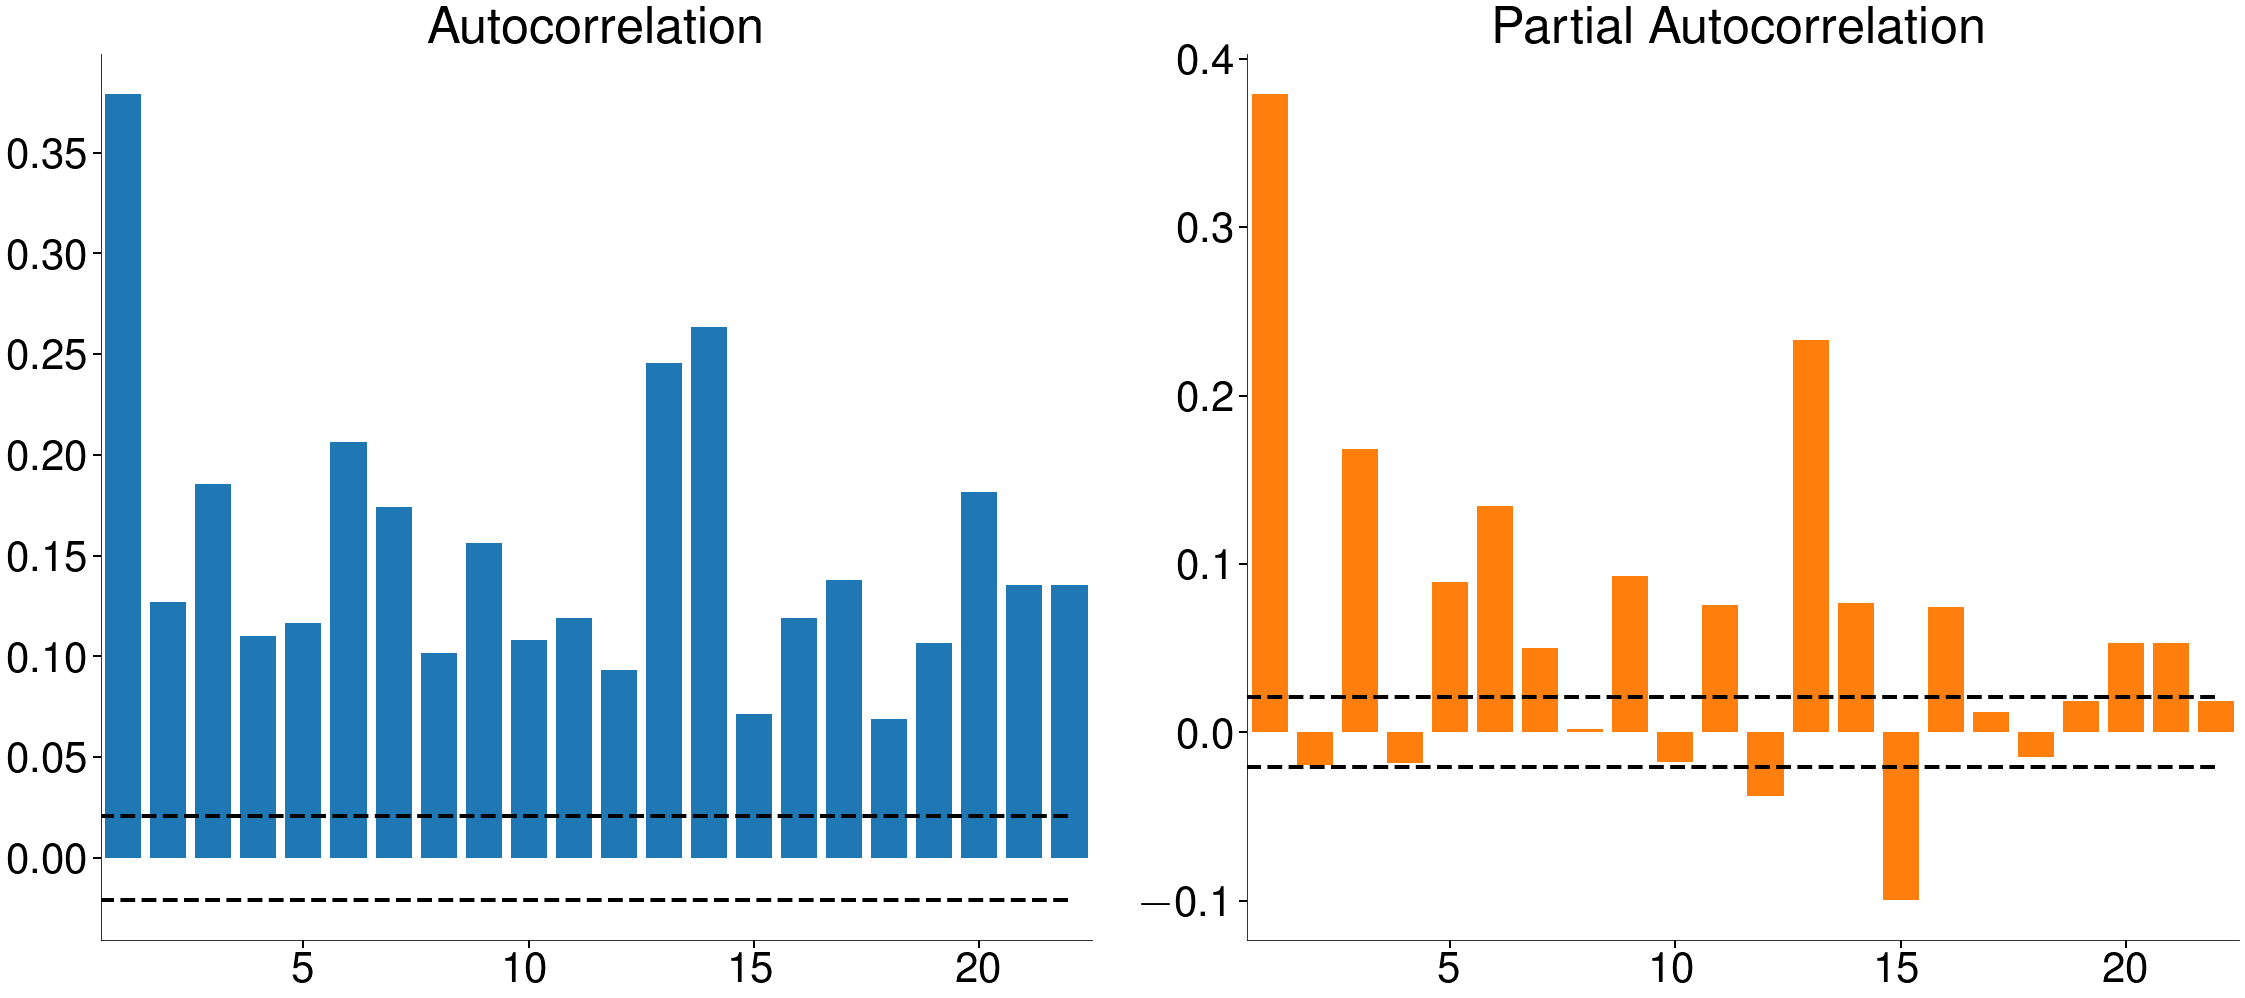

In [9]:
acf_pacf_plot(wti ** 2, 22)

# Bitcoin

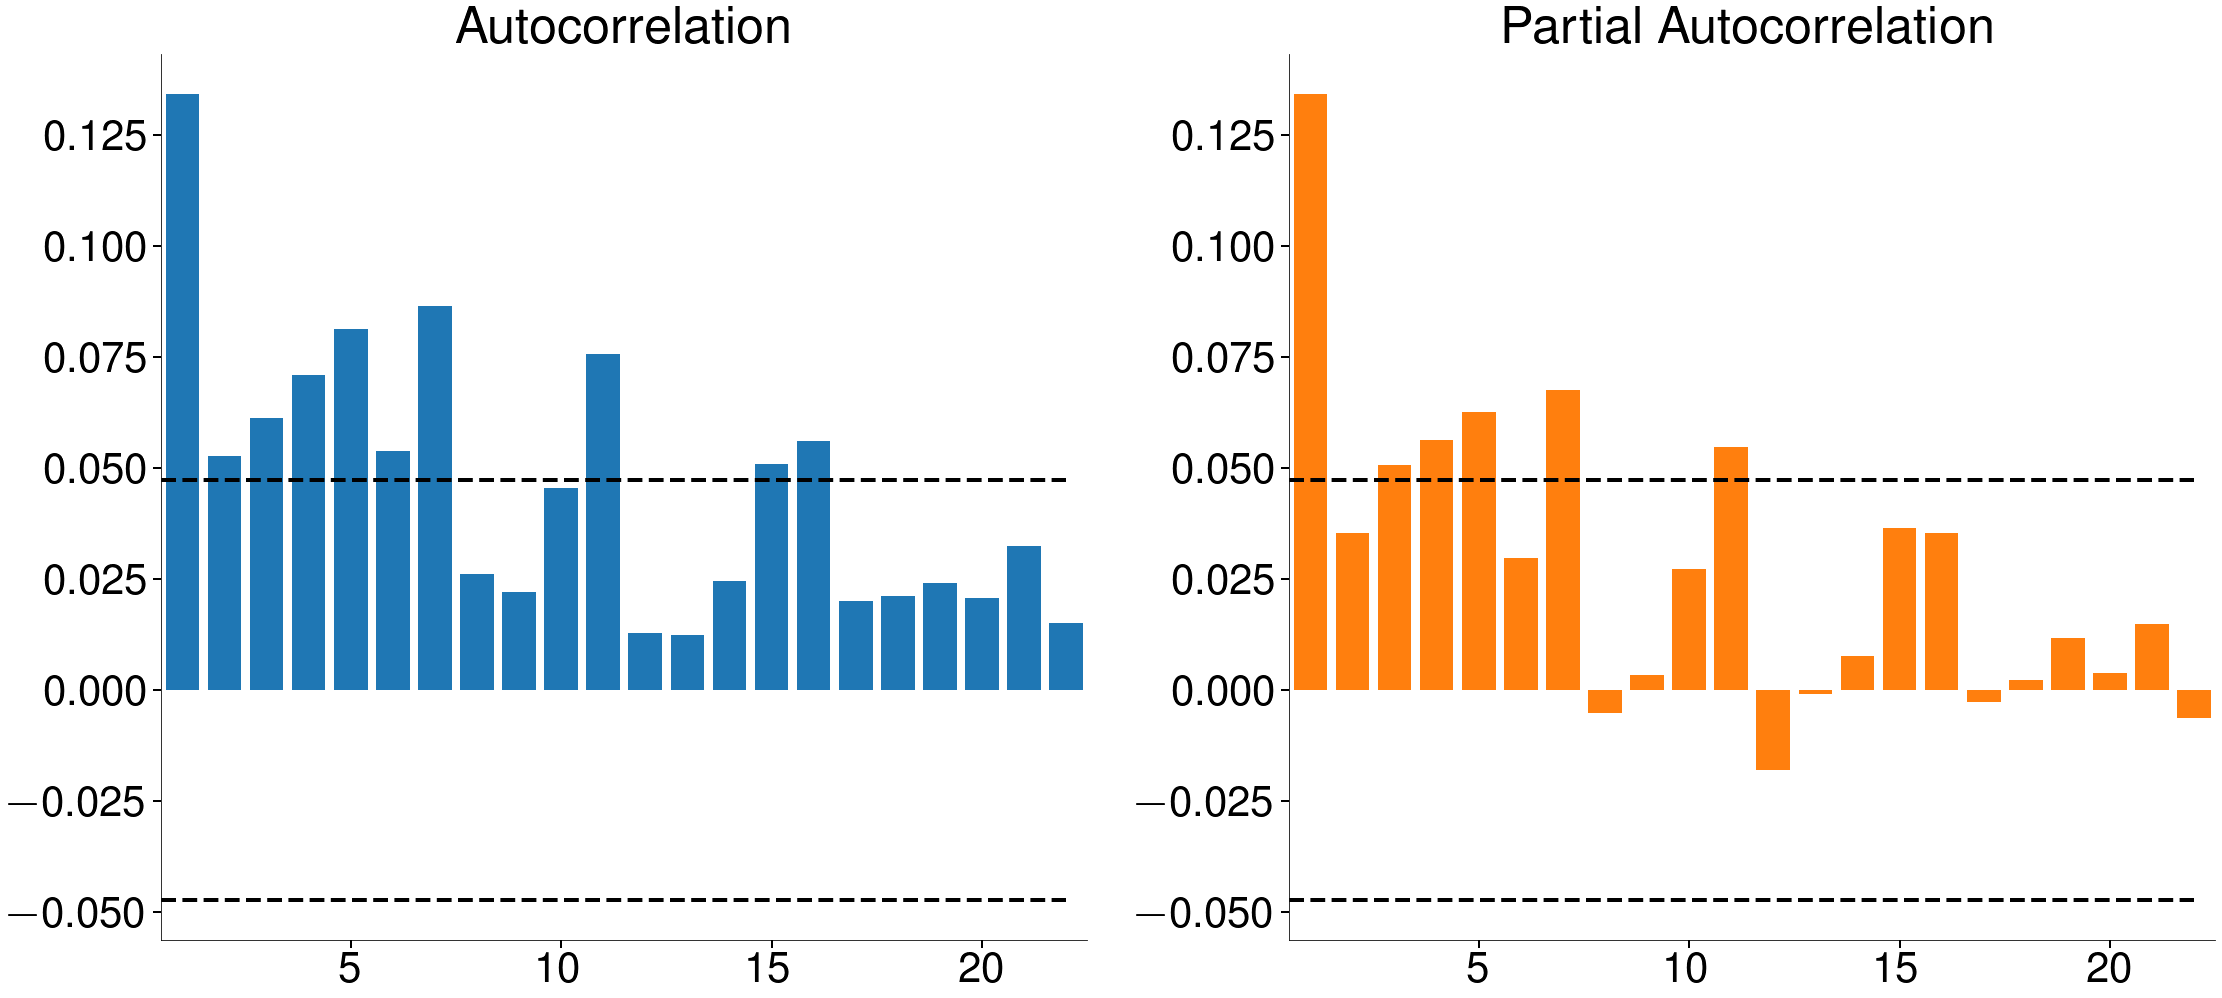

In [10]:
acf_pacf_plot(btc ** 2, 22)

# Etherium

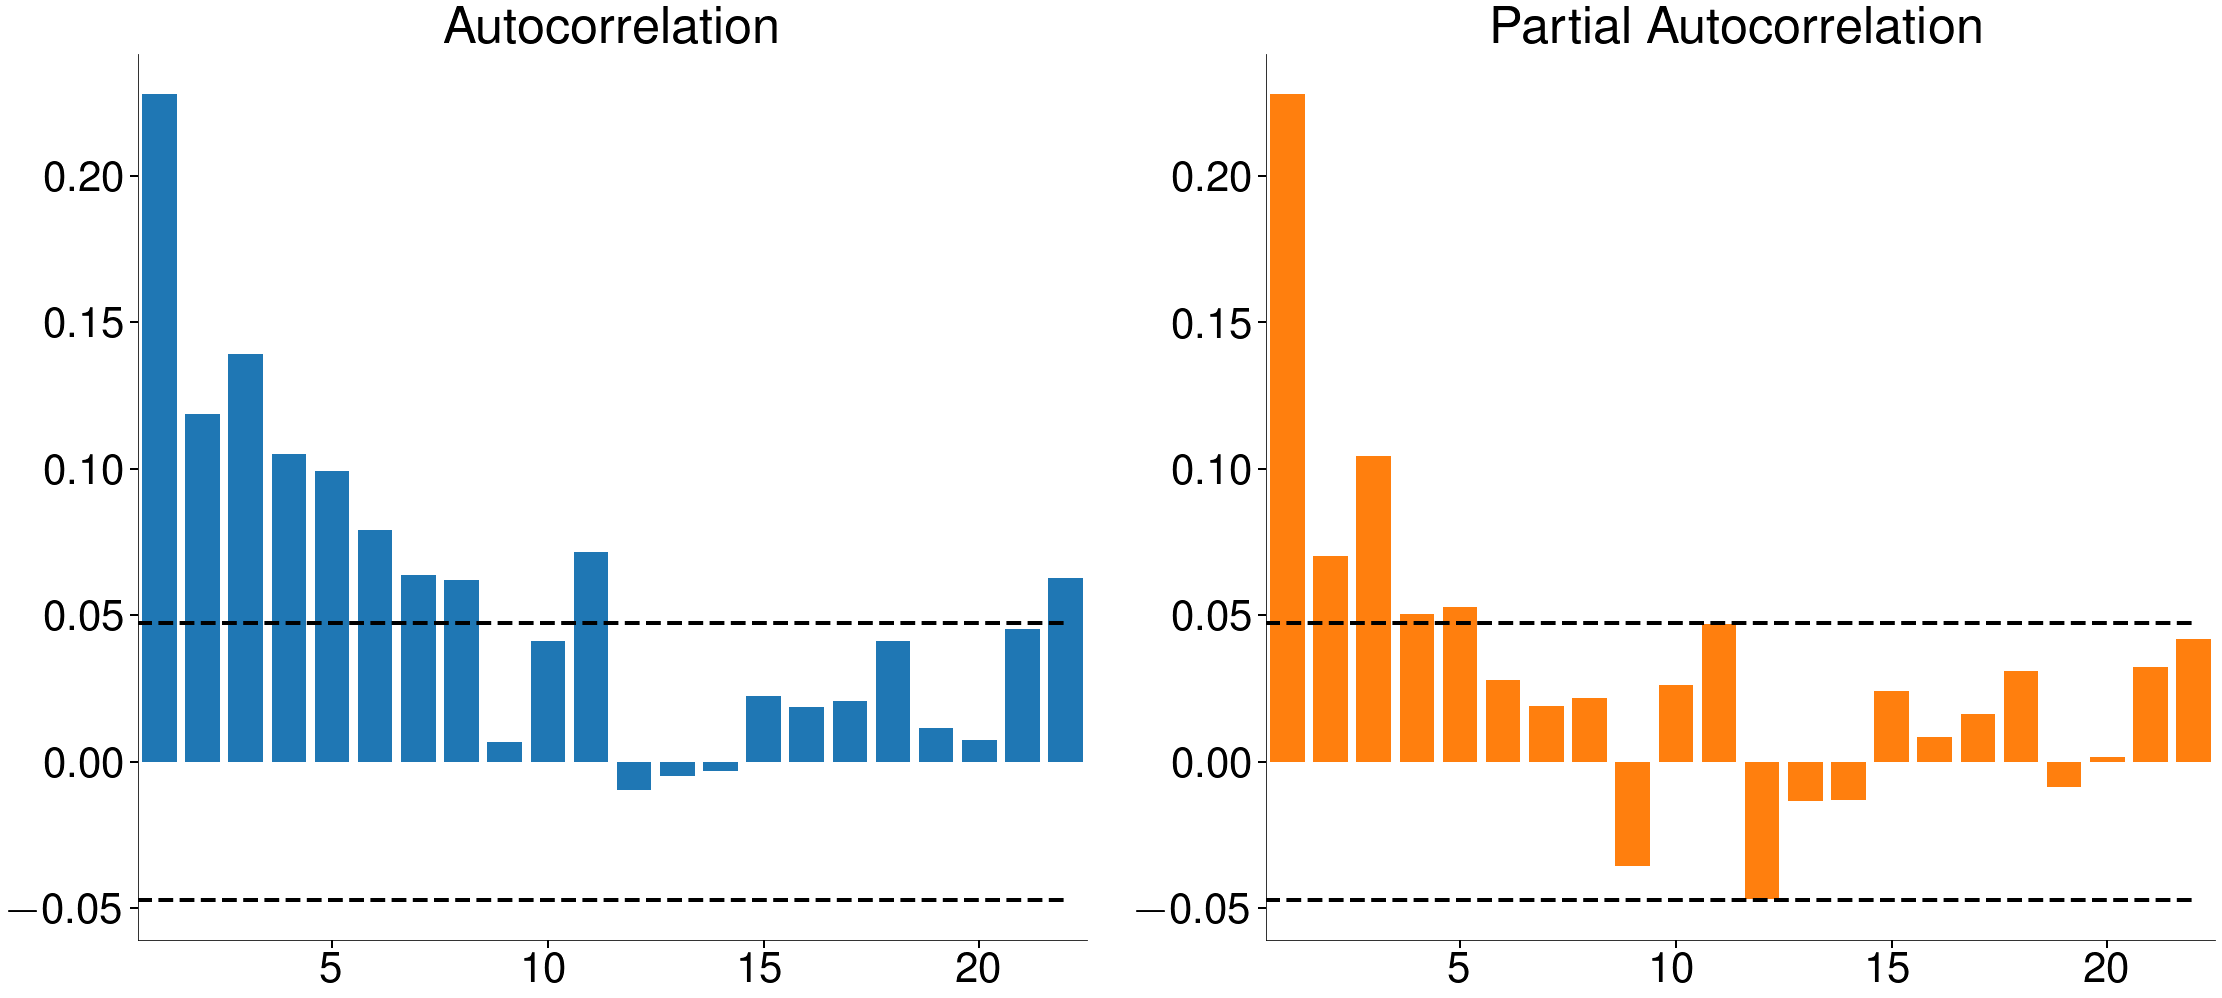

In [11]:
acf_pacf_plot(eth ** 2, 22)

# Model Building

* Usually begin with GARCH
* Check lag specification using StG
* Check for asymmetries using GJR-GARCH
* Check for functional form using TARCH and EGARCH

# Initial Model

In [12]:
garch11 = arch_model(eth).fit(disp="off")
summary(garch11)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5315.65
Vol Model:                      GARCH   AIC:                           10639.3
Distribution:                  Normal   BIC:                           10661.1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2984      0.113      2.643  8.227e-03 [7.709e-02,  0.520]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.3878      1.542      2.197  2.804e-02   [  0.365,  6.410]
alpha[1]       0.1739  4.966e-02      3.503  4.606e-04 [7.661e-02,  0.271]
beta[1]        0.7337  8.177e-02      8.973  2.895e-19   [  0.573,  0.894]
==========================================================================
"""

# Additional Lags

In [13]:
garch21 = arch_model(eth, p=2).fit(disp="off")
summary(garch21)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5315.65
Vol Model:                      GARCH   AIC:                           10641.3
Distribution:                  Normal   BIC:                           10668.6
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2984      0.114      2.623  8.708e-03 [7.546e-02,  0.521]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.3877      1.974      1.716  8.614e-02   [ -0.481,  7.257]
alpha[1]       0.1740  5.461e-02      3.185  1.445e-03 [6.692e-02,  0.281]
alpha[2]       0.0000  7.523e-02      0.000      1.000   [ -0.147,  0.147]
beta[1]        0.7337      0.114      6.441  1.186e-10   [  0.510,  0.957]
==========================================================================
"""

# Additional Lags of Variance

In [14]:
garch12 = arch_model(eth, q=2).fit(disp="off")
summary(garch12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5312.01
Vol Model:                      GARCH   AIC:                           10634.0
Distribution:                  Normal   BIC:                           10661.3
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2985      0.112      2.657  7.890e-03 [7.828e-02,  0.519]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.8956      1.679      2.320  2.036e-02 [  0.604,  7.187]
alpha[1]       0.2135  5.746e-02      3.715  2.031e-04 [  0.101,  0.326]
beta[1]        0.4137      0.109      3.812  1.380e-04 [  0.201,  0.626]
beta[2]        0.2677  8.408e-02      3.184  1.451e-03 [  0.103,  0.433]
========================================================================
"""

In [15]:
# Additional Lags of Both

In [16]:
garch22 = arch_model(eth, p=2, q=2).fit(disp="off")
summary(garch22)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5312.01
Vol Model:                      GARCH   AIC:                           10636.0
Distribution:                  Normal   BIC:                           10668.7
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2985      0.113      2.644  8.186e-03 [7.724e-02,  0.520]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.8949      3.776      1.032      0.302   [ -3.506, 11.296]
alpha[1]       0.2135  7.039e-02      3.033  2.422e-03 [7.552e-02,  0.351]
alpha[2]       0.0000      0.190      0.000      1.000   [ -0.373,  0.373]
beta[1]        0.4137      0.530      0.780      0.435   [ -0.625,  1.453]
beta[2]        0.2678      0.286      0.935      0.350   [ -0.294,  0.829]
==========================================================================
"""

# Asymmetries

In [17]:
gjrgarch112 = arch_model(eth, q=2, o=1).fit(disp="off")
summary(gjrgarch112)

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5311.95
Vol Model:                  GJR-GARCH   AIC:                           10635.9
Distribution:                  Normal   BIC:                           10668.6
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2892      0.115      2.520  1.174e-02 [6.427e-02,  0.514]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.9218      1.660      2.362  1.818e-02   [  0.667,  7.176]
alpha[1]       0.2087  6.364e-02      3.279  1.041e-03 [8.396e-02,  0.333]
gamma[1]       0.0142  7.067e-02      0.201      0.841   [ -0.124,  0.153]
beta[1]        0.4136      0.108      3.827  1.295e-04   [  0.202,  0.625]
beta[2]        0.2657  8.858e-02      3.000  2.703e-03 [9.210e-02,  0.439]
==========================================================================
"""

# Power

In [18]:
tarch112 = arch_model(eth, q=2, o=1, power=1.0).fit(disp="off")
summary(tarch112)

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Constant Mean - TARCH/ZARCH Model Results                   
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5311.64
Vol Model:                TARCH/ZARCH   AIC:                           10635.3
Distribution:                  Normal   BIC:                           10668.0
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3063      0.128      2.401  1.634e-02 [5.629e-02,  0.556]
                               Volatility Model                               
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
omega           0.5484      0.247      2.216  2.671e-02    [6.330e-02,  1.033]
alpha[1]        0.1965  4.514e-02      4.353  1.344e-05      [  0.108,  0.285]
gamma[1]   -4.9817e-03  4.319e-02     -0.115      0.908 [-8.964e-02,7.967e-02]
beta[1]         0.4471  9.875e-02      4.528  5.958e-06      [  0.254,  0.641]
beta[2]         0.3178  9.509e-02      3.342  8.324e-04      [  0.131,  0.504]
==============================================================================
"""

# Log

In [19]:
egarch112 = arch_model(eth, vol="EGARCH", q=2).fit(disp="off")
summary(egarch112)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5308.34
Vol Model:                     EGARCH   AIC:                           10626.7
Distribution:                  Normal   BIC:                           10653.9
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3003      0.121      2.482  1.305e-02 [6.319e-02,  0.537]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3951      0.149      2.658  7.863e-03 [  0.104,  0.686]
alpha[1]       0.3671  7.099e-02      5.171  2.325e-07 [  0.228,  0.506]
beta[1]        0.5440  8.495e-02      6.404  1.514e-10 [  0.377,  0.710]
beta[2]        0.3488  8.511e-02      4.098  4.170e-05 [  0.182,  0.516]
========================================================================
"""

# Pruning

In [20]:
egarch102 = arch_model(eth, vol="EGARCH", o=0, q=2).fit(disp="off")
summary(egarch102)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5308.34
Vol Model:                     EGARCH   AIC:                           10626.7
Distribution:                  Normal   BIC:                           10653.9
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3003      0.121      2.482  1.305e-02 [6.319e-02,  0.537]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3951      0.149      2.658  7.863e-03 [  0.104,  0.686]
alpha[1]       0.3671  7.099e-02      5.171  2.325e-07 [  0.228,  0.506]
beta[1]        0.5440  8.495e-02      6.404  1.514e-10 [  0.377,  0.710]
beta[2]        0.3488  8.511e-02      4.098  4.170e-05 [  0.182,  0.516]
========================================================================
"""

In [21]:
def models():
    mods = (
        garch11,
        garch12,
        garch21,
        garch22,
        gjrgarch112,
        tarch112,
        egarch112,
        egarch102,
    )
    tab = []
    names = [
        "GARCH(1,1)",
        "GARCH(1,2)",
        "GARCH(2,1)",
        "GARCH(2,2)",
        "GJR(1,1,2)",
        "TARCH(1,1,2)",
        "EGARCH(1,1,2)",
        "EGARCH(1,0,2)",
    ]
    for mod in mods:
        temp = mod.params.copy()
        temp = temp.append(
            pd.Series({"LLF": mod.loglikelihood, "AIC": mod.aic, "BIC": mod.bic})
        )
        tab.append(temp)
        temp = mod.tvalues.copy()
        temp = temp.append(pd.Series({"LLF": np.nan, "AIC": np.nan, "BIC": np.nan}))
        tab.append(temp)
    df = pd.concat(tab, 1).T
    df = df.applymap(lambda v: f"{v:0.3f}" if not np.isnan(v) else "")
    col = []
    for name in names:
        col += [name, " "]
    df.index = col
    for col in ("LLF", "AIC", "BIC"):
        df[col] = df[col].apply(lambda v: "{0:0.1f}".format(float(v)) if v else "")
    df = df[
        [
            "omega",
            "alpha[1]",
            "alpha[2]",
            "gamma[1]",
            "beta[1]",
            "beta[2]",
            "LLF",
            "AIC",
            "BIC",
        ]
    ]
    return df

# Summary

In [22]:
models()

,omega,alpha[1],alpha[2],gamma[1],beta[1],beta[2],LLF,AIC,BIC
"GARCH(1,1)",3.388,0.174,,,0.734,,-5315.7,10639.3,10661.1
,2.197,3.503,,,8.973,,,,
"GARCH(1,2)",3.896,0.213,,,0.414,0.268,-5312.0,10634.0,10661.3
,2.320,3.715,,,3.812,3.184,,,
"GARCH(2,1)",3.388,0.174,0.000,,0.734,,-5315.7,10641.3,10668.6
,1.716,3.185,0.000,,6.441,,,,
"GARCH(2,2)",3.895,0.213,0.000,,0.414,0.268,-5312.0,10636.0,10668.7
,1.032,3.033,0.000,,0.780,0.935,,,
"GJR(1,1,2)",3.922,0.209,,0.014,0.414,0.266,-5311.9,10635.9,10668.6
,2.362,3.279,,0.201,3.827,3.000,,,


# Specification Checking

* Conceptually similar to mean modeling
* Emphasis of different form of residual

$$ \hat{e}_t^2 = \frac{\hat{\epsilon}_t^2}{\hat{\sigma}_t^2}$$

* Check ACF/PACF for White Noise appearance

# ACF and PACF of $\hat{e}^2_t$

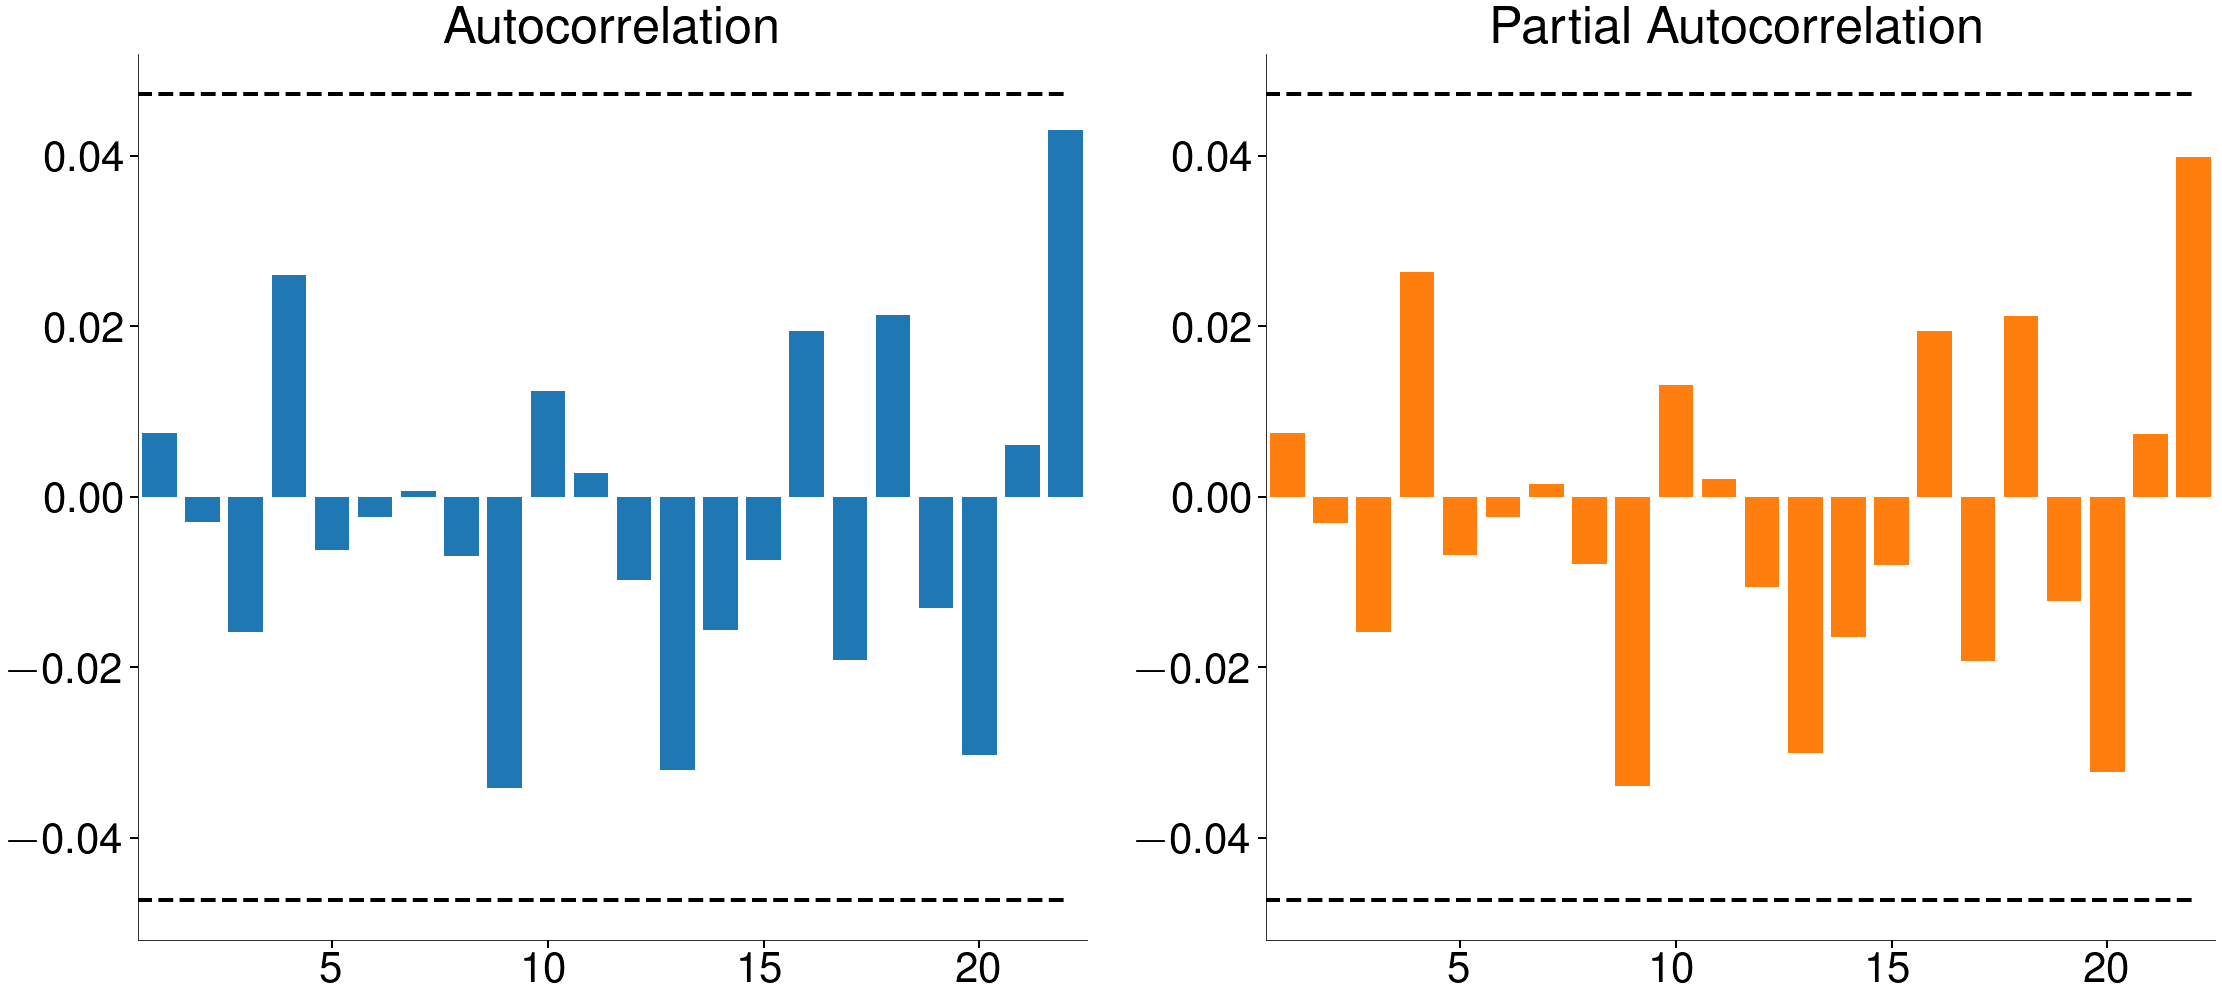

In [23]:
acf_pacf_plot(egarch102.std_resid ** 2, 22)

# ARCH-LM test

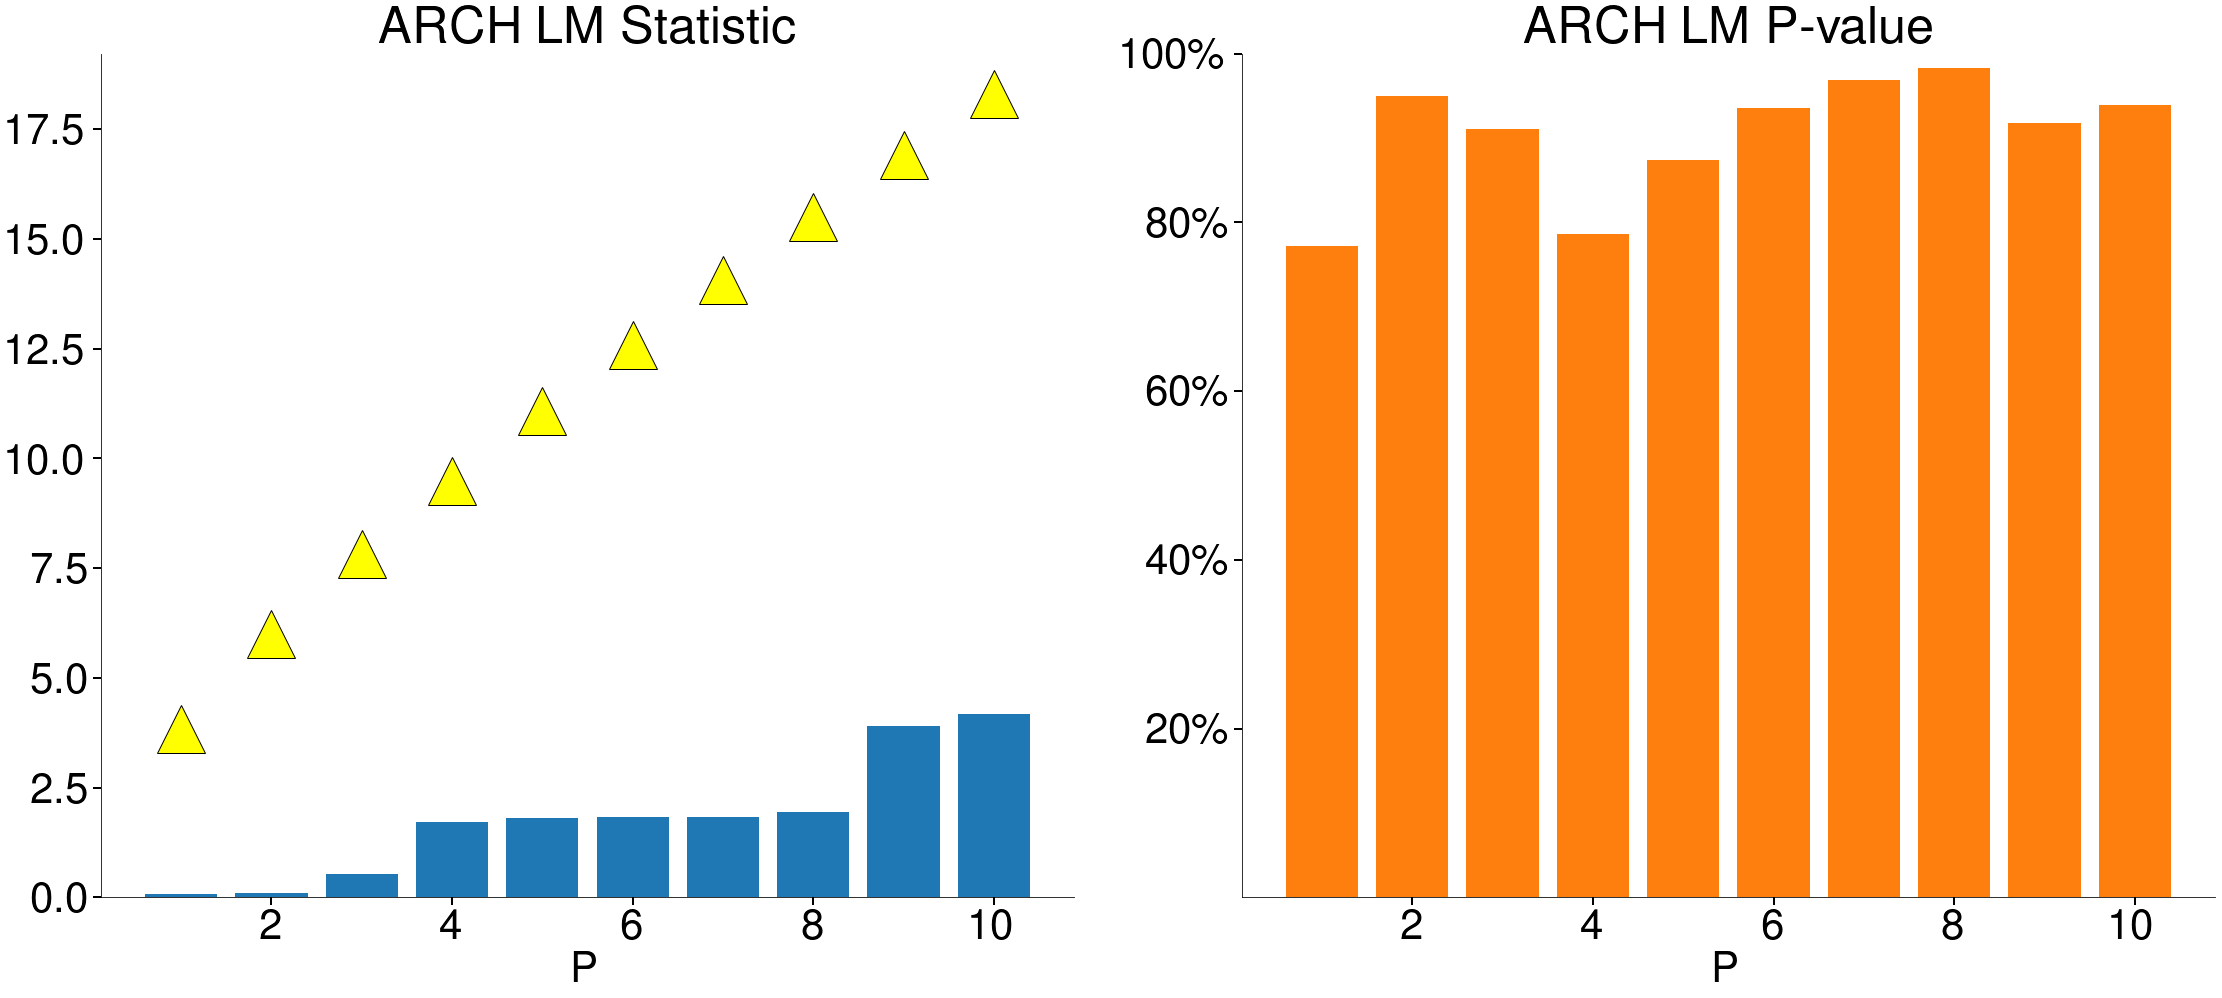

In [24]:
arch_lm(egarch102.std_resid, 10)

# Alternative Distributional Assumptions

* Have assumed $e_t \stackrel{iid}{\sim} N(0,1)$
* Can relax this assumption
* Common alternatives:
  * Student's $t$
  * Generalized Error Distribution
  * Hansen's Skew $t$

# Baseline Normal

In [25]:
normal = arch_model(sp500, o=1, vol="egarch").fit(disp="off")
summary(normal, mean=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -13681.8
Vol Model:                     EGARCH   AIC:                           27373.6
Distribution:                  Normal   BIC:                           27409.8
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.8410e-03  2.112e-03      1.345      0.179 [-1.299e-03,6.981e-03]
alpha[1]       0.1587  1.692e-02      9.380  6.584e-21      [  0.126,  0.192]
gamma[1]      -0.1040  1.256e-02     -8.280  1.229e-16   [ -0.129,-7.935e-02]
beta[1]        0.9757  4.241e-03    230.054      0.000      [  0.967,  0.984]
=============================================================================
"""

# Standardized Student's $t$

* Student's $t$ normalized to always have variance 1
* $\nu$ controls tail thickness
  * $\nu > 2$ required for variance to be finite


In [26]:
studt = arch_model(sp500, o=1, vol="egarch", dist="t").fit(disp="off")
summary(studt, mean=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - EGARCH Model Results                        
====================================================================================
Mean Model:                   Constant Mean   Log-Likelihood:               -13408.6
Vol Model:                           EGARCH   AIC:                           26829.2
Distribution:      Standardized Student's t   BIC:                           26872.7
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.8400e-03  1.820e-03      1.011      0.312 [-1.728e-03,5.407e-03]
alpha[1]       0.1489  1.025e-02     14.524  8.578e-48      [  0.129,  0.169]
gamma[1]      -0.1040  8.646e-03    -12.027  2.562e-33   [ -0.121,-8.704e-02]
beta[1]        0.9825  2.586e-03    379.953      0.000      [  0.977,  0.988]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.4774      0.436     14.865  5.545e-50 [  5.623,  7.331]
========================================================================
"""

# Generalized Error Distribution

* Nests the normal when $\nu=2$
* Heavy tailed for $\nu<2$
  * Infinite variance for $\nu\leq 1$

In [27]:
ged = arch_model(sp500, o=1, vol="egarch", dist="ged").fit(disp="off")
summary(ged, mean=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - EGARCH Model Results                           
==========================================================================================
Mean Model:                         Constant Mean   Log-Likelihood:               -13426.3
Vol Model:                                 EGARCH   AIC:                           26864.6
Distribution:      Generalized Error Distribution   BIC:                           26908.0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.3248e-03  1.841e-03      0.720      0.472 [-2.284e-03,4.933e-03]
alpha[1]       0.1514  1.178e-02     12.848  8.804e-38      [  0.128,  0.174]
gamma[1]      -0.1025  9.533e-03    -10.752  5.810e-27   [ -0.121,-8.381e-02]
beta[1]        0.9805  2.975e-03    329.522      0.000      [  0.975,  0.986]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.3358  3.350e-02     39.879      0.000 [  1.270,  1.401]
========================================================================
"""

# Hansen's Skew $t$

* Extendeds the $t$ with a skewness parameter $\lambda$

In [28]:
skewt = arch_model(sp500, o=1, vol="egarch", dist="skewt").fit(disp="off")
summary(skewt, mean=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - EGARCH Model Results                          
=========================================================================================
Mean Model:                        Constant Mean   Log-Likelihood:               -13394.4
Vol Model:                                EGARCH   AIC:                           26802.9
Distribution:      Standardized Skew Student's t   BIC:                           26853.6
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.1877e-03  1.928e-03      1.653  9.826e-02 [-5.911e-04,6.966e-03]
alpha[1]       0.1494  1.012e-02     14.757  2.755e-49      [  0.130,  0.169]
gamma[1]      -0.1058  8.618e-03    -12.271  1.296e-34   [ -0.123,-8.886e-02]
beta[1]        0.9815  2.622e-03    374.306      0.000      [  0.976,  0.987]
                                 Distribution                                 
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
nu             6.6500      0.452     14.718  4.950e-49       [  5.764,  7.536]
lambda        -0.0705  1.241e-02     -5.683  1.323e-08 [-9.487e-02,-4.621e-02]
==============================================================================
"""

# Comparing Volatility

In [29]:
names = ["Normal", "Student's $t$", "GED", "Skew $t$"]


def compare_volatility(annualize=False, span=None):
    df = pd.concat(
        [
            normal.conditional_volatility,
            studt.conditional_volatility,
            ged.conditional_volatility,
            skewt.conditional_volatility,
        ],
        1,
    )
    df.columns = names
    if annualize:
        df *= np.sqrt(252)
    if span is not None:
        df = df.loc[span]
    plot(df)

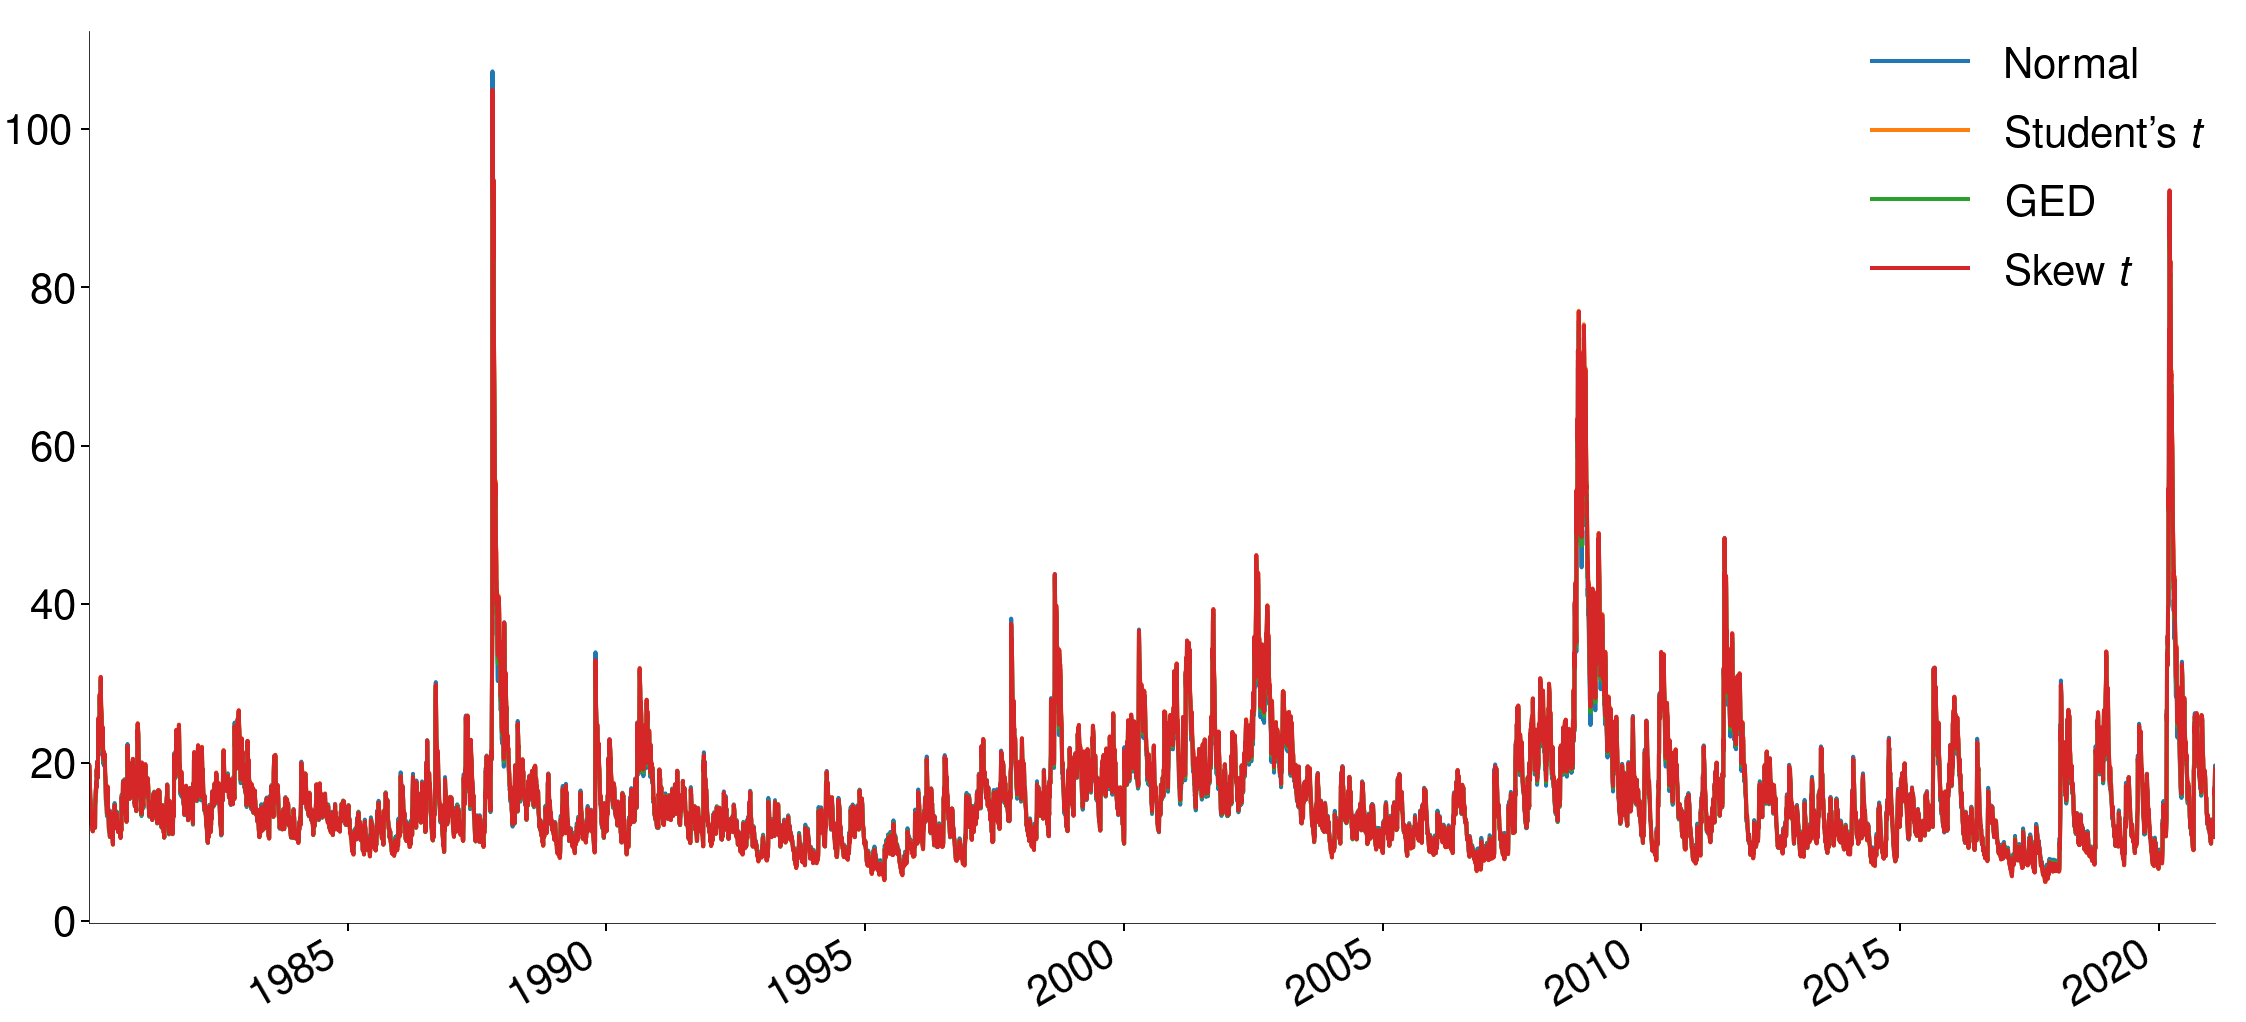

In [30]:
compare_volatility(annualize=True)

# Comparing Volatility in 2020

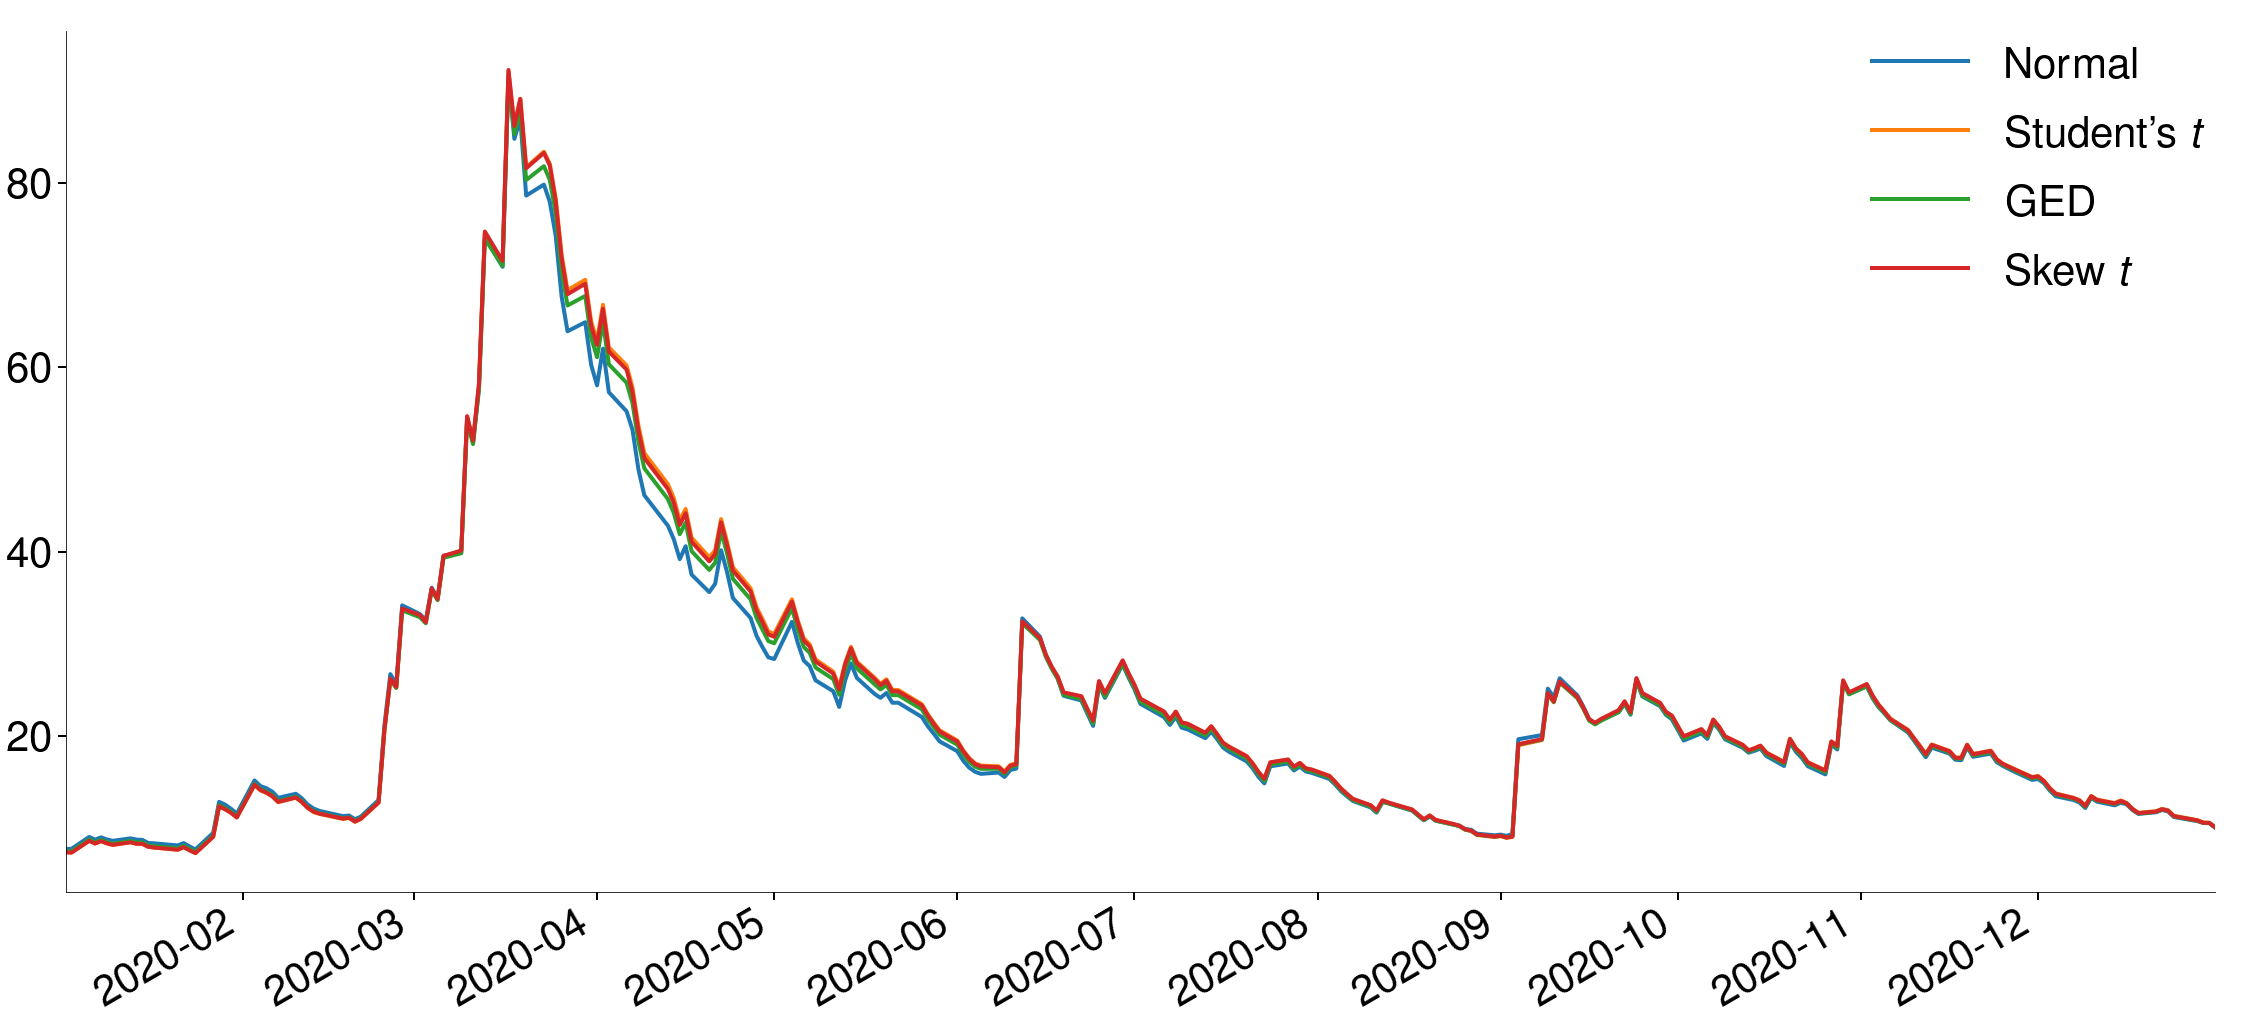

In [31]:
compare_volatility(annualize=True, span="2020")

In [32]:
from statsmodels.nonparametric.kde import KDEUnivariate

vals = [
    normal.model.distribution.simulate(None)(1000000),
    studt.model.distribution.simulate(studt.params.iloc[-1])(1000000),
    ged.model.distribution.simulate(ged.params.iloc[-1])(1000000),
    skewt.model.distribution.simulate(skewt.params.iloc[-2:])(1000000),
]

res = {}
for v, n in zip(vals, names):
    kde = KDEUnivariate(v)
    kde.fit(bw=0.1)
    res[n] = (kde.support, kde.density)

In [33]:
def compare_dist(tails=False):
    fig, ax = plt.subplots(1, 1)
    for key in res:
        ax.plot(res[key][0], res[key][1], label=key)
    if tails:
        ax.set_xlim(-3, -2)
        lim = 0
        for key in res:
            x = res[key][0]
            y = res[key][1]
            lim = max(y[x <= -2].max(), lim)
        ax.set_ylim(0, 1.1 * lim)
    else:
        ax.set_xlim(-3, 3)
        ax.set_ylim(0, ax.get_ylim()[1])
    ax.legend(frameon=False)
    sns.despine()
    fig.tight_layout(pad=1.0)

# Comparing the estimated distributions

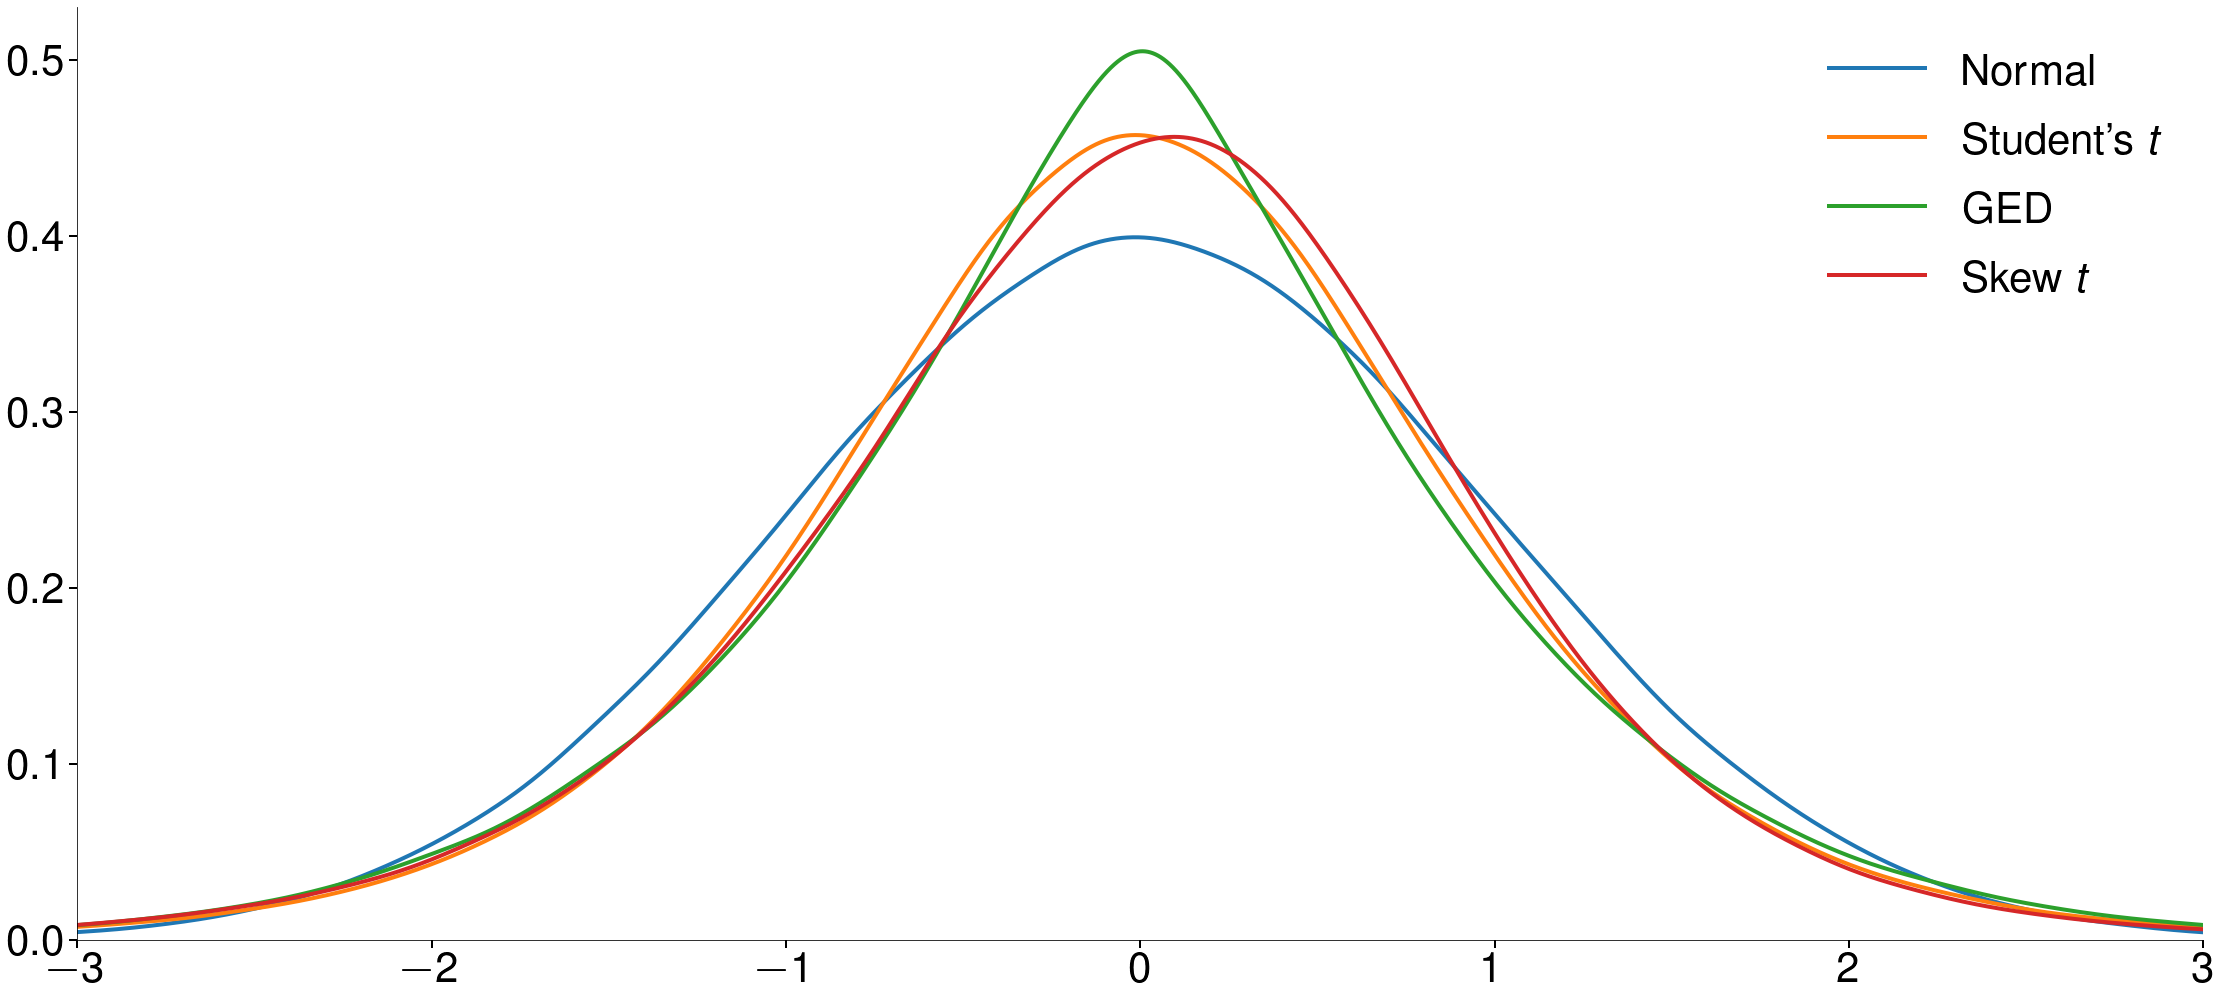

In [34]:
compare_dist()

# Comparing the Tails

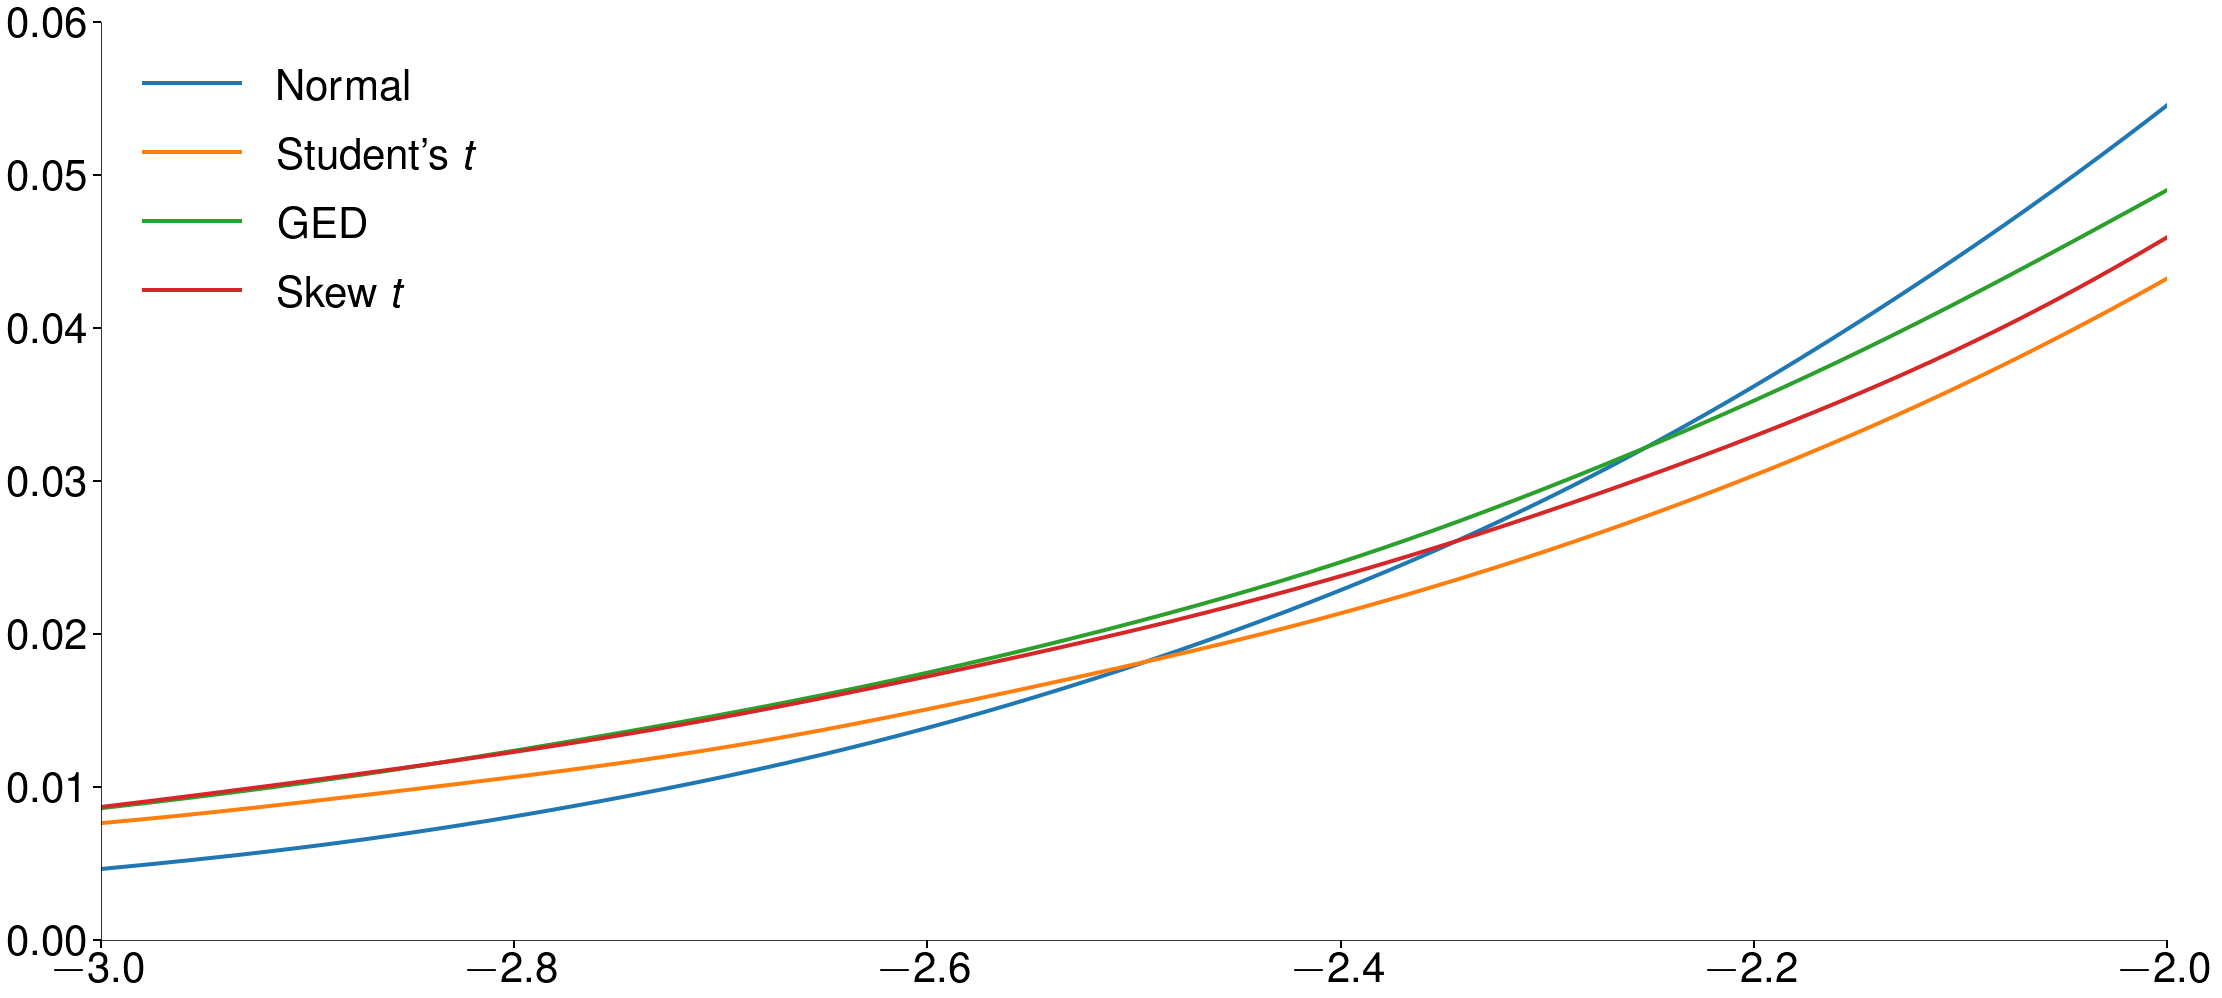

In [35]:
compare_dist(tails=True)

# Forecasting

* Forecasting follows the same principles as in ARMA models
* Multi-step forecasts computed recursively

$$ \mathrm{E}_t[\epsilon_{t+h}^2] = \mathrm{E}_t[\sigma^2_{t+h}] $$

* One-step is always known at time $t$
* Non-linear models are harder to use in multi-step forecasts
* **Solution**:  Simulate or bootstrap
* Long-run forecast converges to unconditional variance

# GARCH forecasting

In [36]:
mid = sp500.index[sp500.shape[0] // 2]
res = arch_model(sp500).fit(last_obs=mid, disp="off")
forecasts = res.forecast(start=mid).variance.dropna()

# Forecasts

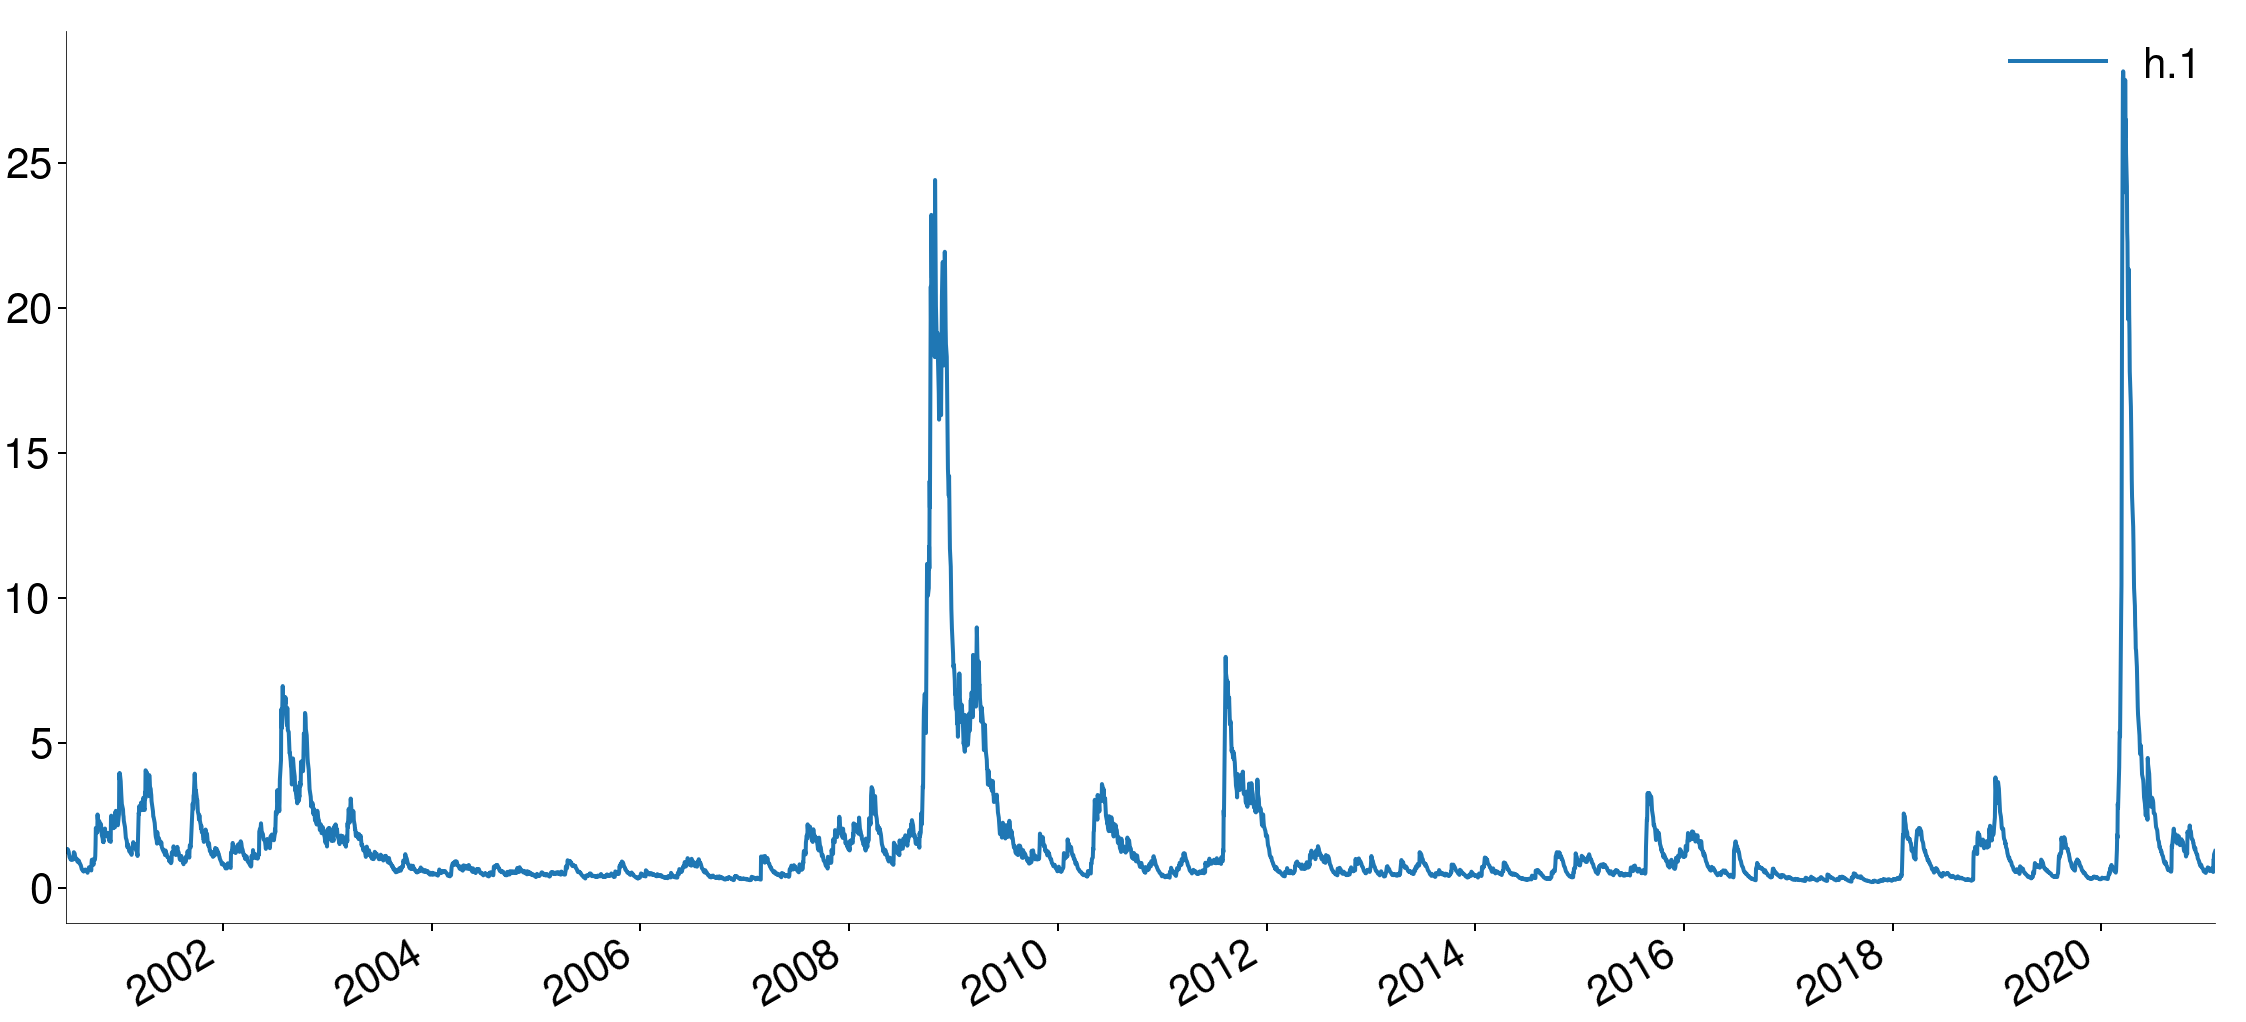

In [37]:
plot(forecasts)

# Multi-step forecasts

In [38]:
forecasts = res.forecast(horizon=10, start=mid).variance.dropna()
forecasts.head()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2000-06-29,1.306535,1.306075,1.305620,1.305168,1.304720,1.304275,1.303835,1.303398,1.302964,1.302535
2000-06-30,1.261279,1.261200,1.261121,1.261043,1.260966,1.260889,1.260813,1.260738,1.260663,1.260589
2000-07-03,1.239720,1.239822,1.239923,1.240023,1.240122,1.240221,1.240319,1.240416,1.240512,1.240607
2000-07-05,1.335551,1.334847,1.334150,1.333458,1.332772,1.332092,1.331418,1.330749,1.330086,1.329428
2000-07-06,1.276561,1.276353,1.276147,1.275943,1.275741,1.275540,1.275341,1.275143,1.274947,1.274753


# Multi-step forecasts: $h=10$

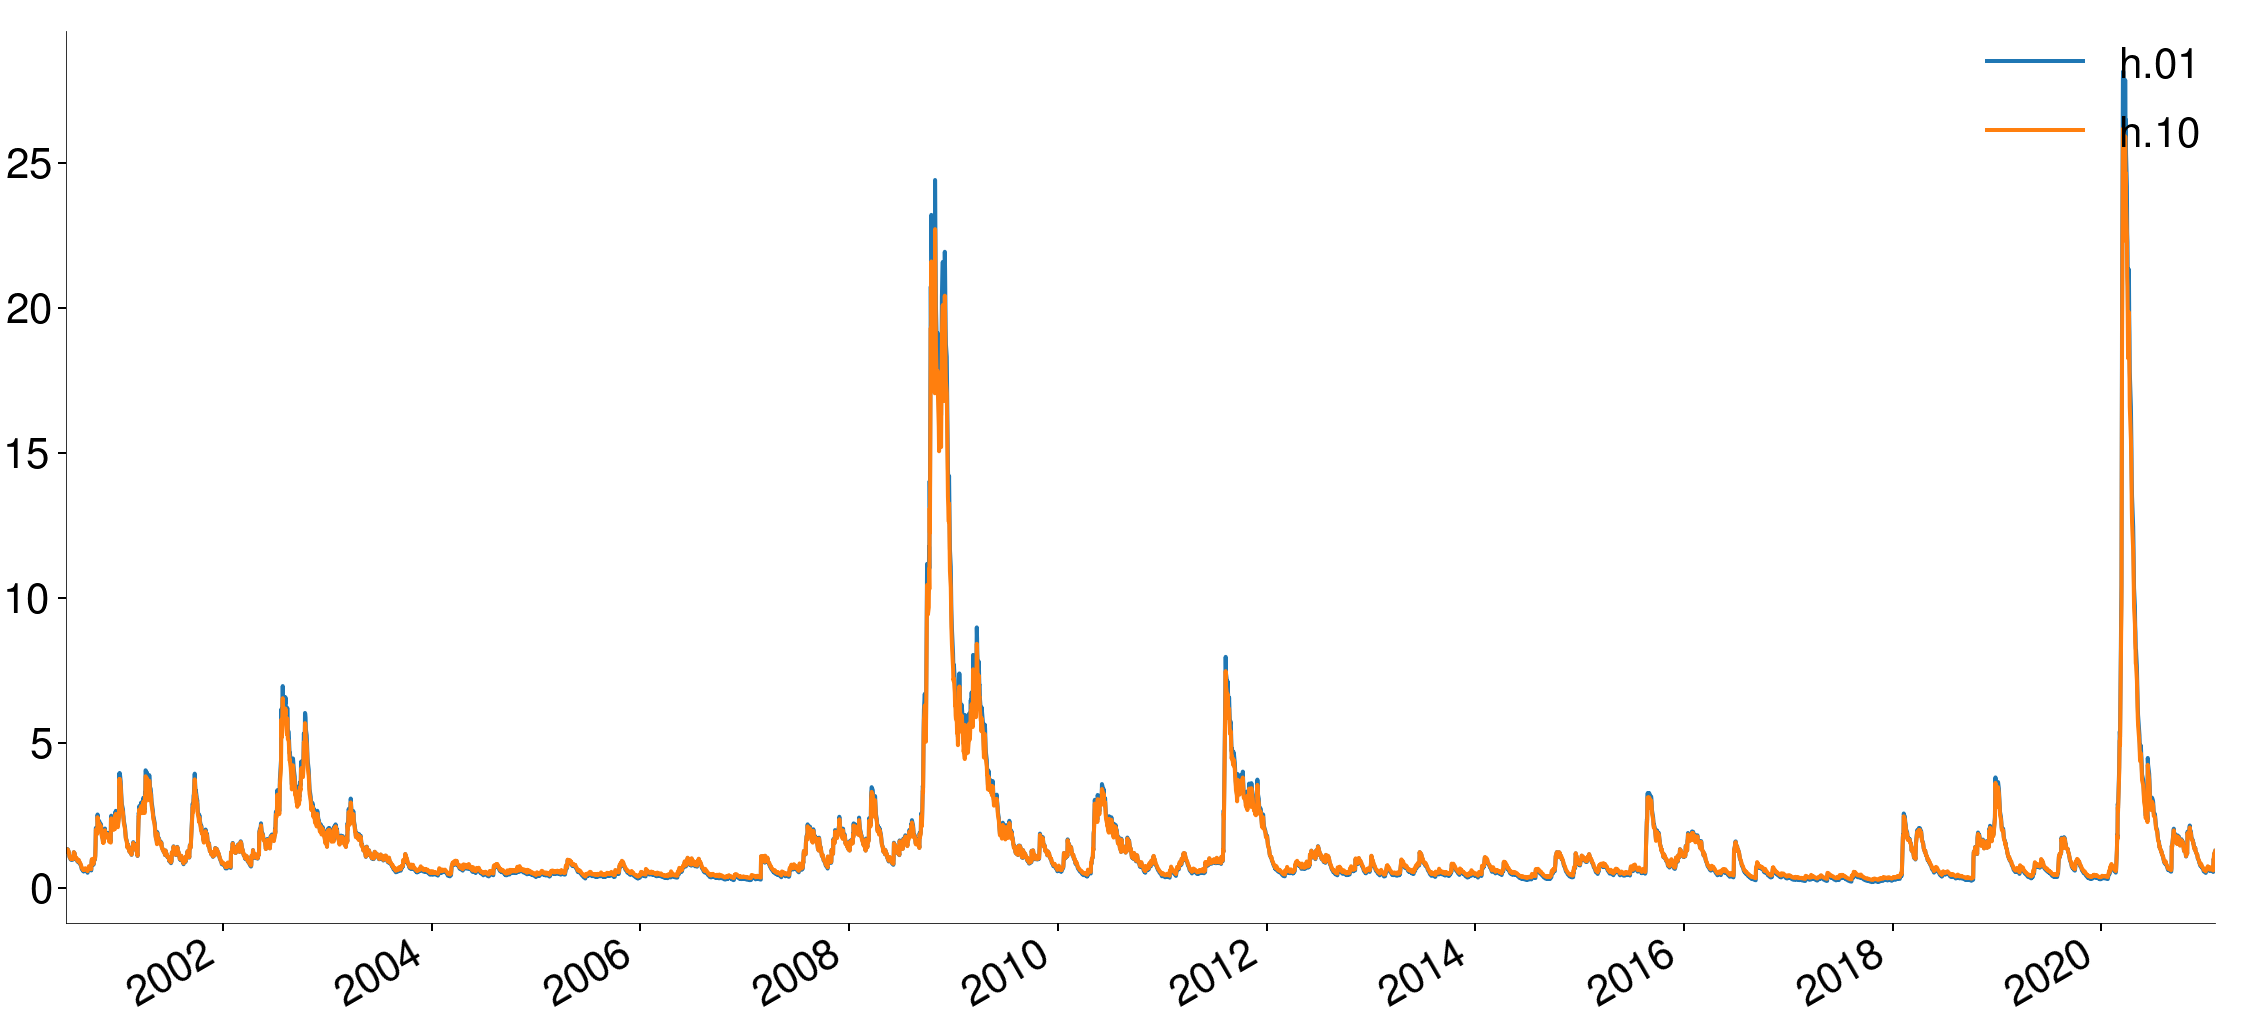

In [39]:
plot(forecasts[["h.01", "h.10"]])

In [40]:
forecasts = res.forecast(horizon=252, start=mid).variance.dropna()

# Multi-step forecasts: $h=252$

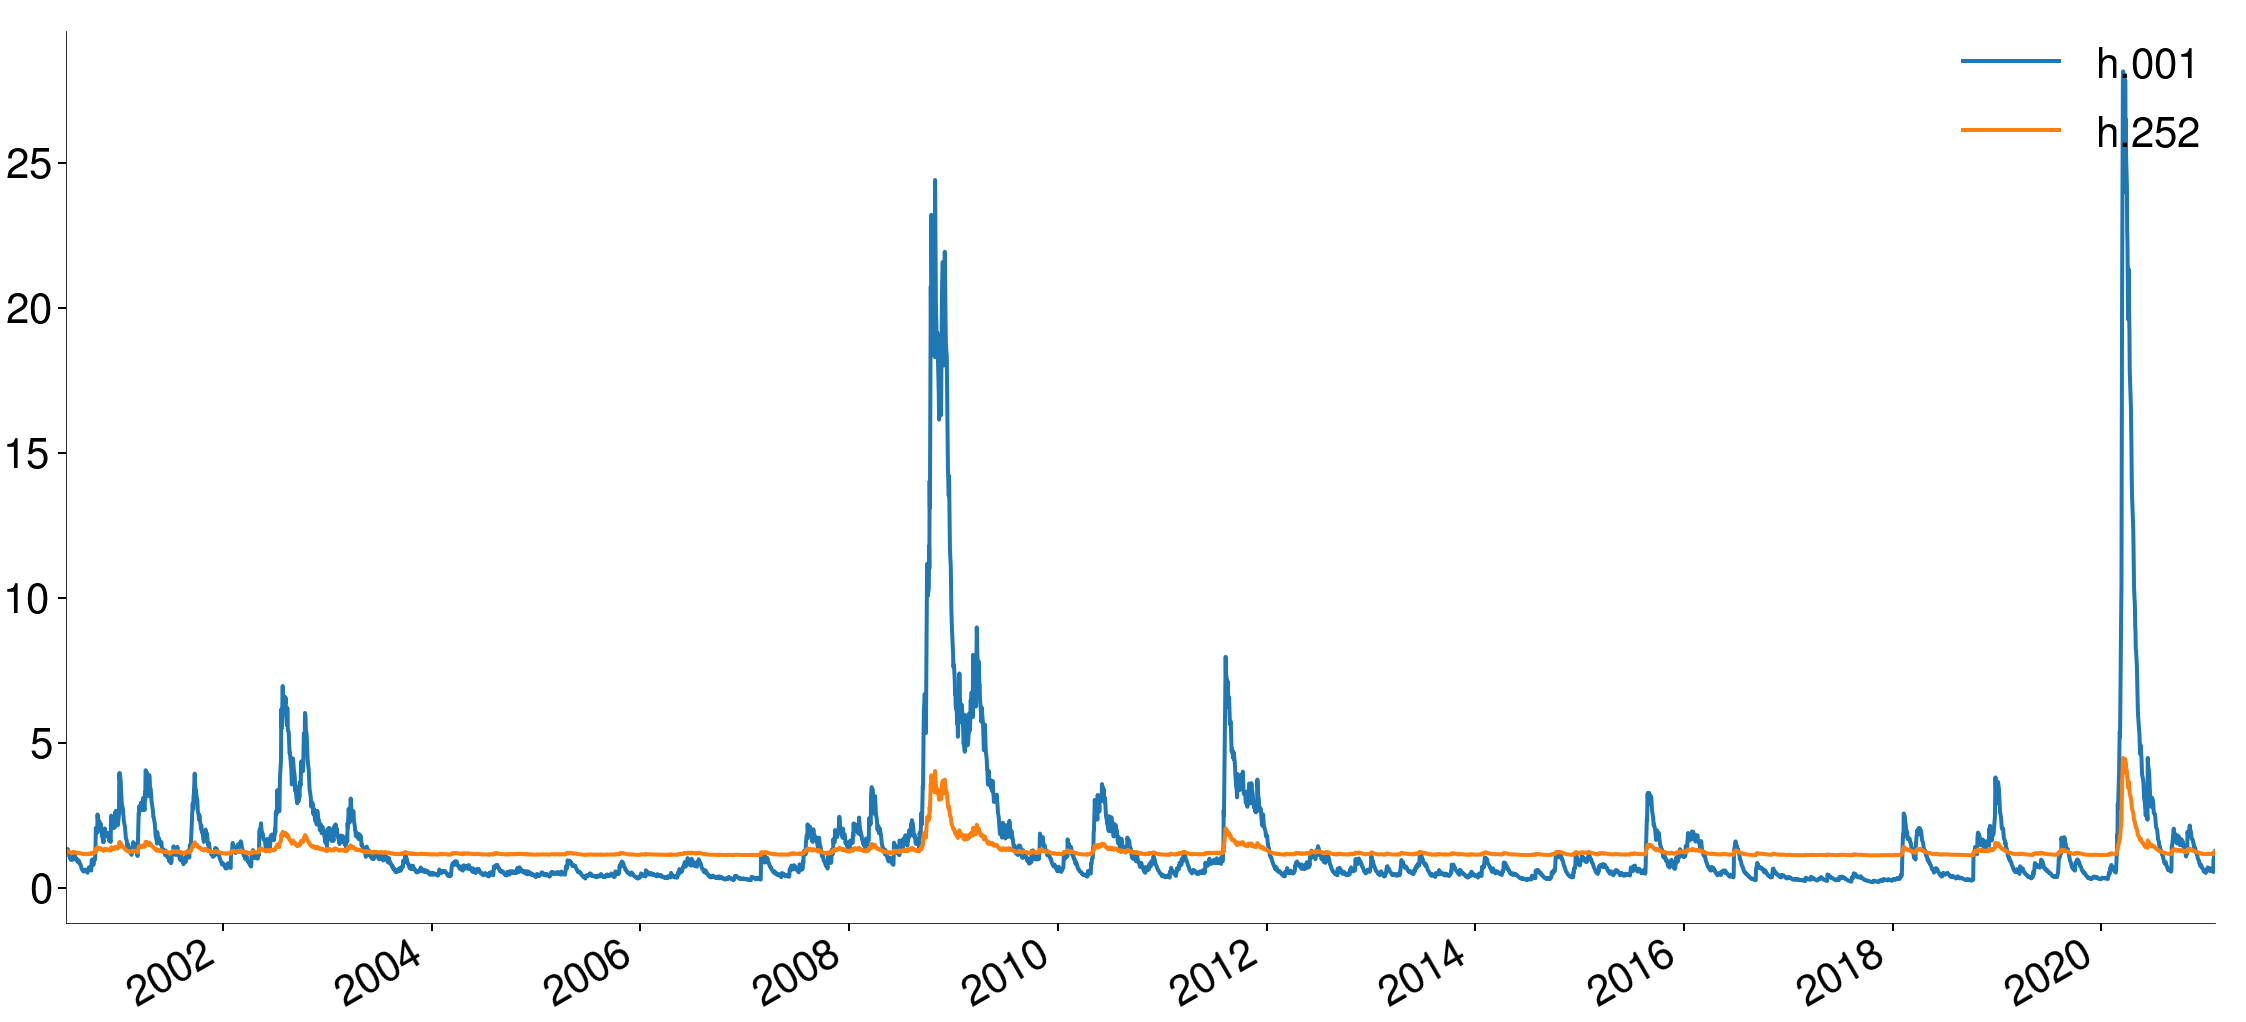

In [41]:
plot(forecasts[["h.001", "h.252"]])

# Forecast Evaluation
## Objective

* Objective evaluation uses MZ regression

$$ \epsilon_{t+h}^2 - \hat{\sigma}^2_{t+h|t} = \alpha + \beta \hat{\sigma}^2_{t+h|t} + \eta_t $$

* Null: $\alpha=\beta=0$
* GLS version improves power

$$ \frac{\epsilon_{t+h}^2 - \hat{\sigma}^2_{t+h|t}}{\hat{\sigma}^2_{t+h|t}} = \alpha\frac{1}{\hat{\sigma}^2_{t+h|t}} + \beta \times 1 + \eta_t $$

* Exploits structure of model where $\epsilon_{t+h} = e_{t+h} \sigma_{t+h}$

$$ \mathrm{V}_t[\epsilon^2_{t+h}] \propto \sigma_{t+h|t}^4 $$


# LHS Construction

In [42]:
forecasts = res.forecast(horizon=1, start=mid, align="target").variance.dropna()
comb = pd.concat([sp500 ** 2 - res.params["mu"], forecasts], 1).dropna()
errors = comb["S&P 500"] - comb["h.1"]
errors.head()

Date
2000-06-30   -0.653226
2000-07-03   -0.269632
2000-07-05    1.213088
2000-07-06   -0.877707
2000-07-07    0.989097
dtype: float64

In [43]:
import statsmodels.api as sm

# MZ Regression

In [44]:
res = sm.OLS(errors, sm.add_constant(comb["h.1"])).fit()
mfe.slides.summary(res)

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.0539,0.079,-0.680,0.496,-0.209,0.101
h.1,0.0159,0.026,0.609,0.542,-0.035,0.067


In [45]:
def wald_test(res, r):
    stat = res.wald_test(r)
    return pd.DataFrame(
        [[np.round(float(stat.fvalue), 3)], [np.round(stat.pvalue, 3)], [stat.df_num]],
        index=["Stat", "P-value", "Deg of Freedom"],
        columns=["Wald Test Results"],
    )

# Wald Test

In [46]:
wald_test(res, np.eye(2))

,Wald Test Results
Stat,0.280
P-value,0.756
Deg of Freedom,2.000


# MZ-GLS Estimation

In [47]:
h1 = comb["h.1"].to_numpy()
x = sm.add_constant(comb["h.1"]) / h1[:, None]
gls = sm.OLS(errors / h1, x).fit()
mfe.slides.summary(gls)

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.0888,0.029,-3.079,0.002,-0.145,-0.032
h.1,0.0199,0.049,0.406,0.685,-0.076,0.116


# MZ-GLS Wald Test

In [48]:
wald_test(gls, np.eye(2))

,Wald Test Results
Stat,12.795
P-value,0.000
Deg of Freedom,2.000


# Using WLS

In [49]:
wls = sm.WLS(errors, sm.add_constant(comb["h.1"]), weights=1 / comb["h.1"] ** 2).fit()
mfe.slides.summary(wls)

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.0888,0.029,-3.079,0.002,-0.145,-0.032
h.1,0.0199,0.049,0.406,0.685,-0.076,0.116


# WLS Wald Test

In [50]:
wald_test(wls, np.eye(2))

,Wald Test Results
Stat,12.795
P-value,0.000
Deg of Freedom,2.000


# Forecast Evaluation
## Relative

* Standard DM Test
* MSE loss

$$ l\left(\epsilon^2_{t+h},\hat{\sigma}_{t+h|t}^2\right)  = \left(\epsilon^2_{t+h} -\hat{\sigma}_{t+h|t}^2 \right)^2$$

* QLIK Loss

$$ l\left(\epsilon^2_{t+h},\hat{\sigma}_{t+h|t}^2\right) = \ln \hat{\sigma}_{t+h|t}^2 + \frac{\epsilon^2_{t+h}}{\hat{\sigma}_{t+h|t}^2}$$

# DM Setup

In [51]:
from arch.univariate import EWMAVariance, ConstantMean

In [52]:
ewma = EWMAVariance(0.94)
ewma_res = ConstantMean(sp500, volatility=ewma).fit(disp="off", last_obs=mid)
ewma_forecast = ewma_res.forecast(start=mid, align="target").variance.dropna()
relative = pd.concat([comb, ewma_forecast], 1).dropna()
relative.columns = ["S&P 500", "GARCH", "EWMA"]
relative.head()

,S&P 500,GARCH,EWMA
Date,,,
2000-06-30,0.653309,1.306535,1.466028
2000-07-03,0.991647,1.261279,1.415143
2000-07-05,2.452808,1.239720,1.386303
2000-07-06,0.457844,1.335551,1.465807
2000-07-07,2.265658,1.276561,1.404111


# Constructing $\delta_t$

In [53]:
la = (relative["S&P 500"] - relative.GARCH) ** 2
lb = (relative["S&P 500"] - relative.EWMA) ** 2
delta = la - lb
delta.head()

Date
2000-06-30   -0.233808
2000-07-03   -0.106648
2000-07-05    0.334150
2000-07-06   -0.245620
2000-07-07    0.236050
dtype: float64

# DM Testing

In [54]:
res = sm.OLS(delta, np.ones_like(delta)).fit(cov_type="HAC", cov_kwds={"maxlags": 10})
mfe.slides.summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.4836,0.194,-2.487,0.013,-0.865,-0.103


# MSE $\delta_t$

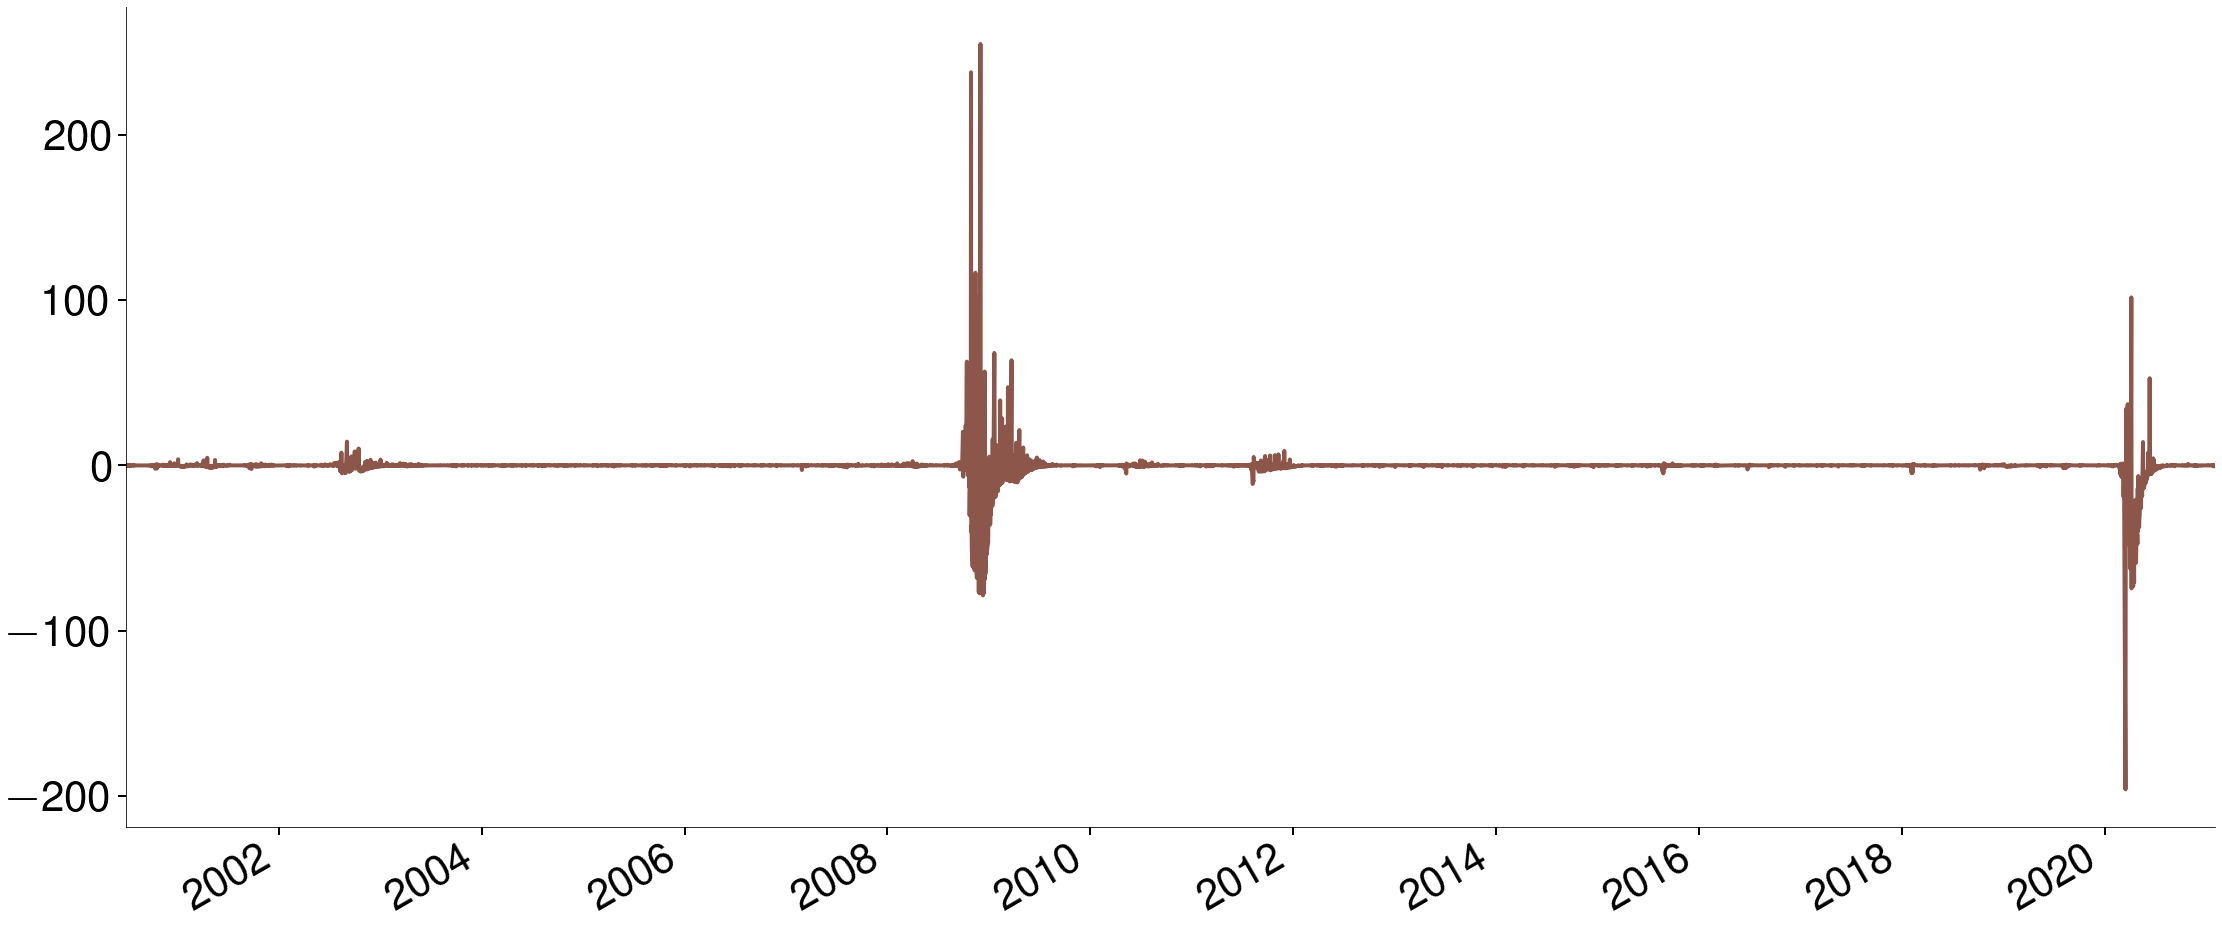

In [55]:
plot(delta, y=14)

# QLIK Loss Construction

In [56]:
la = np.log(relative.GARCH) + relative["S&P 500"] / relative.GARCH
lb = np.log(relative.EWMA) + relative["S&P 500"] / relative.EWMA
delta = la - lb
delta.head()

Date
2000-06-30   -0.060778
2000-07-03   -0.029621
2000-07-05    0.097447
2000-07-06   -0.062599
2000-07-07    0.065990
dtype: float64

# Testing using QLIK

In [57]:
res = sm.OLS(delta, np.ones_like(delta)).fit(cov_type="HAC", cov_kwds={"maxlags": 10})
mfe.slides.summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0047,0.010,-0.470,0.638,-0.024,0.015


# QLIK $\delta_t$

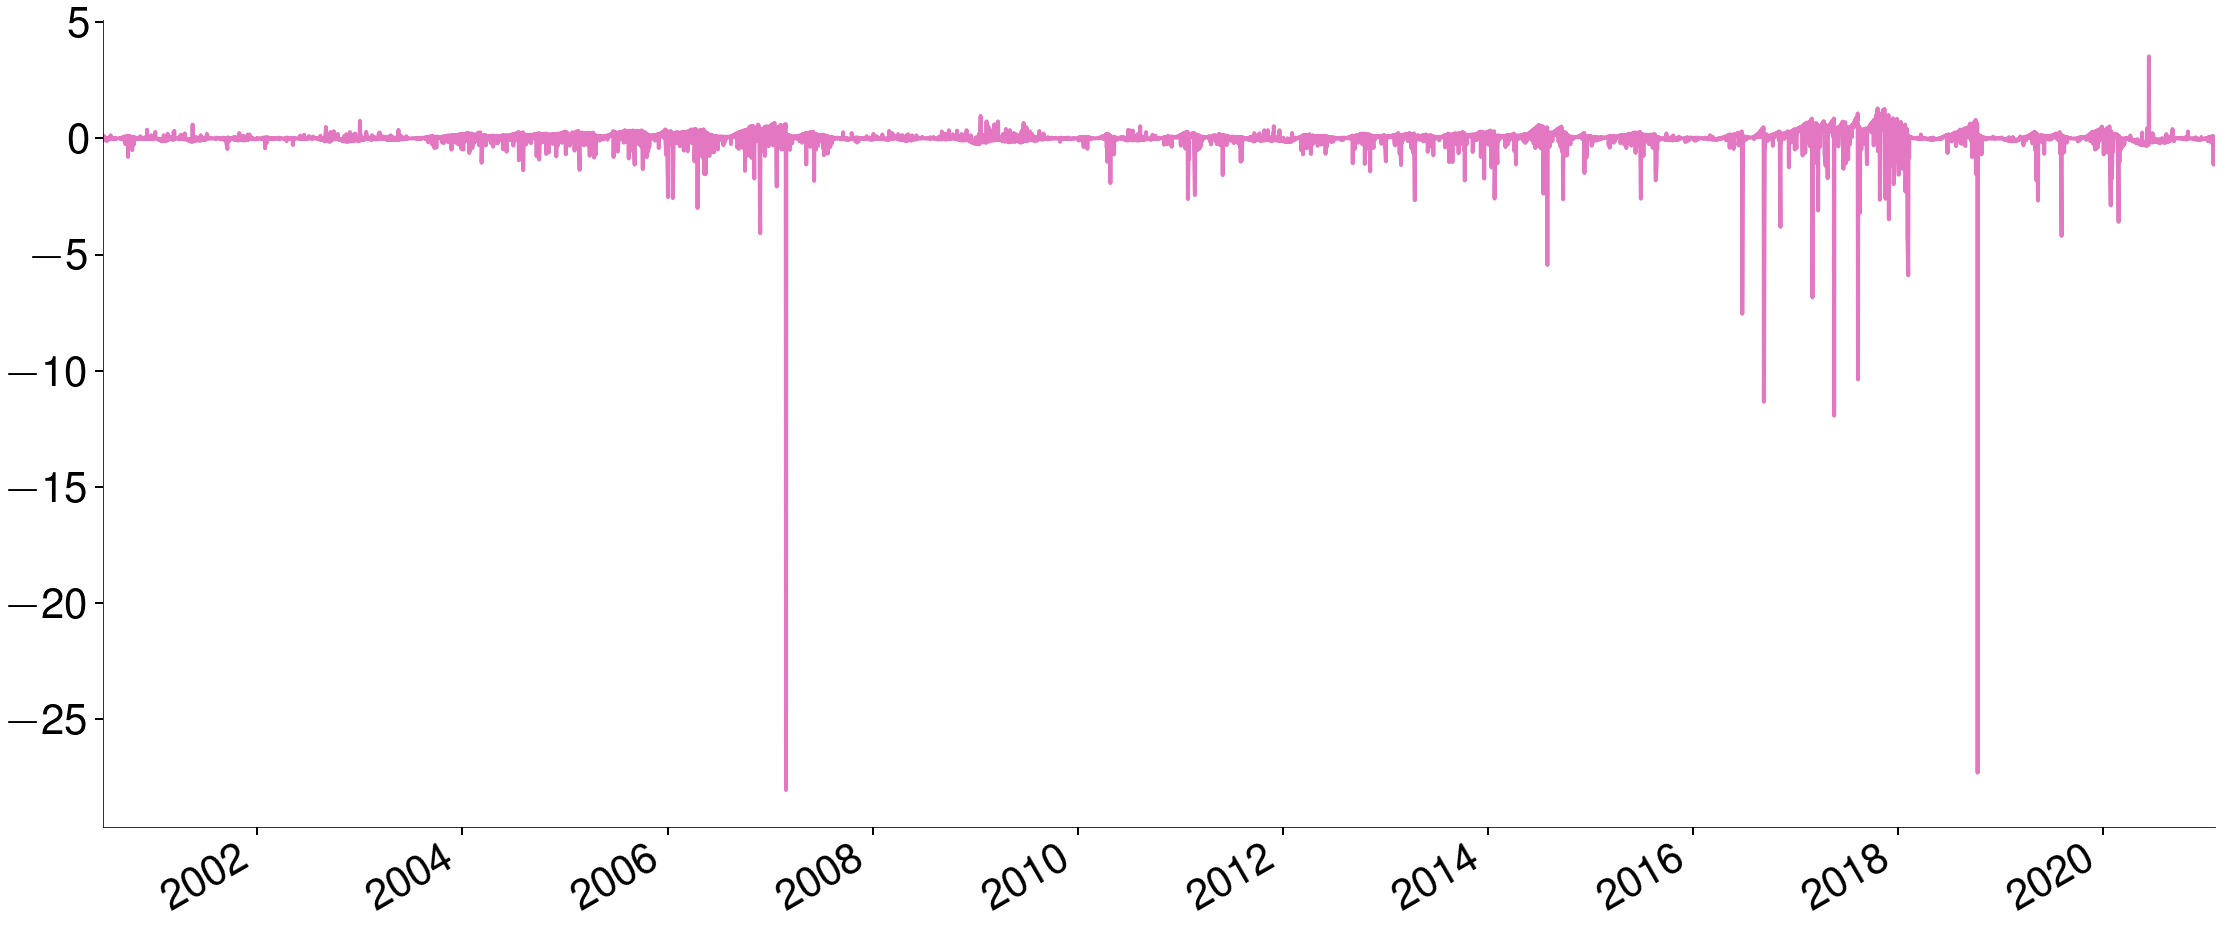

In [58]:
plot(delta, y=14)

# Next Week

## Univariate Volatility Modeling

* Realized Variance
* Implied Variance